In [ ]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


RANDOM FOREST IMAGE SEGMENTATION - LOCAL VERSION

######################################################################
# RANDOM FOREST IMAGE SEGMENTATION
######################################################################

Enter your dataset path:
Example (Windows): C:\Users\YourName\Desktop\my_dataset
Example (Mac/Linux): /home/yourname/Desktop/my_dataset

Your dataset should have this structure:
  my_dataset/
    ├── images/
    │   ├── img1.jpg
    │   ├── img2.jpg
    └── masks/
        ├── img1.png
        ├── img2.png

Dataset path: /content/drive/MyDrive/Data_2

######################################################################
# RANDOM FOREST IMAGE SEGMENTATION PIPELINE
######################################################################

STEP 1: LOAD DATASET

✓ Loading dataset from: /content/drive/MyDrive/Data_2
  Found 20 images

✓ Successfully loaded 20 image-mask pairs
  Classes found in masks: [  0 255]

✓ Visualizing 4 samples from dataset...


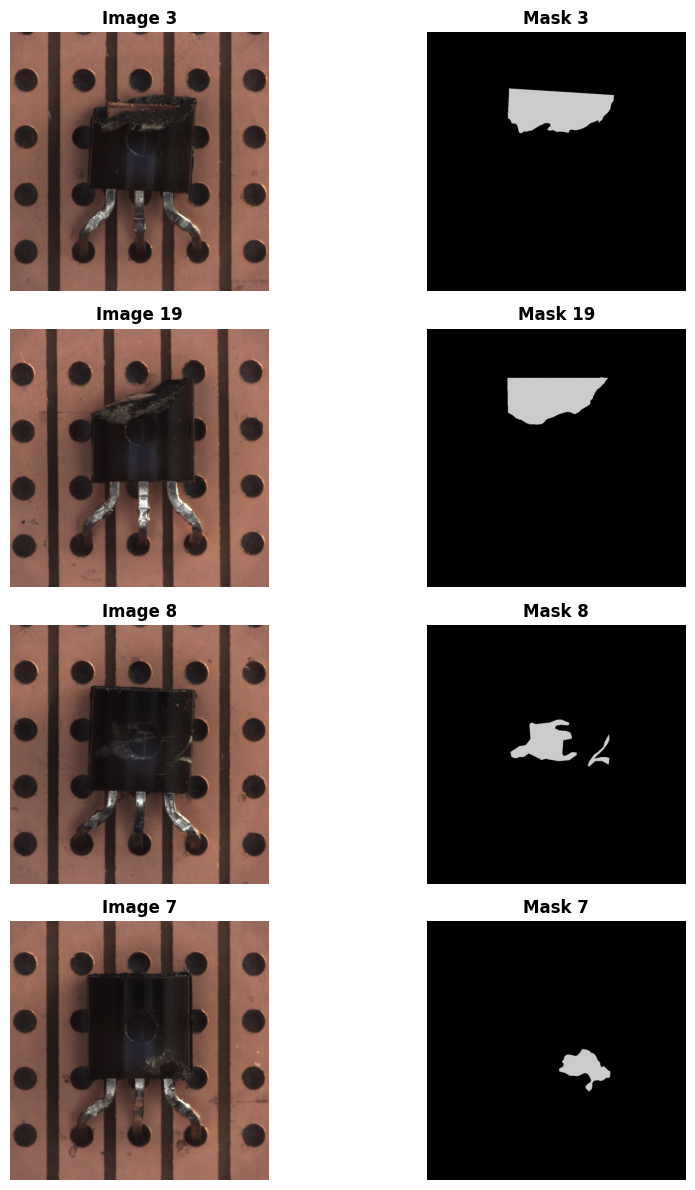


PREPARING TRAINING DATA

✓ Processing 20 images...
  Processing image 1/20...
✓ Extracting multi-scale features (σ=1 to 16)...
  Feature shape: (1024, 1024, 60)
  Features per pixel: 60
  Processing image 2/20...
✓ Extracting multi-scale features (σ=1 to 16)...
  Feature shape: (1024, 1024, 60)
  Features per pixel: 60
  Processing image 3/20...
✓ Extracting multi-scale features (σ=1 to 16)...
  Feature shape: (1024, 1024, 60)
  Features per pixel: 60
  Processing image 4/20...
✓ Extracting multi-scale features (σ=1 to 16)...
  Feature shape: (1024, 1024, 60)
  Features per pixel: 60
  Processing image 5/20...
✓ Extracting multi-scale features (σ=1 to 16)...
  Feature shape: (1024, 1024, 60)
  Features per pixel: 60
  Processing image 6/20...
✓ Extracting multi-scale features (σ=1 to 16)...
  Feature shape: (1024, 1024, 60)
  Features per pixel: 60
  Processing image 7/20...
✓ Extracting multi-scale features (σ=1 to 16)...
  Feature shape: (1024, 1024, 60)
  Features per pixel: 60
  P

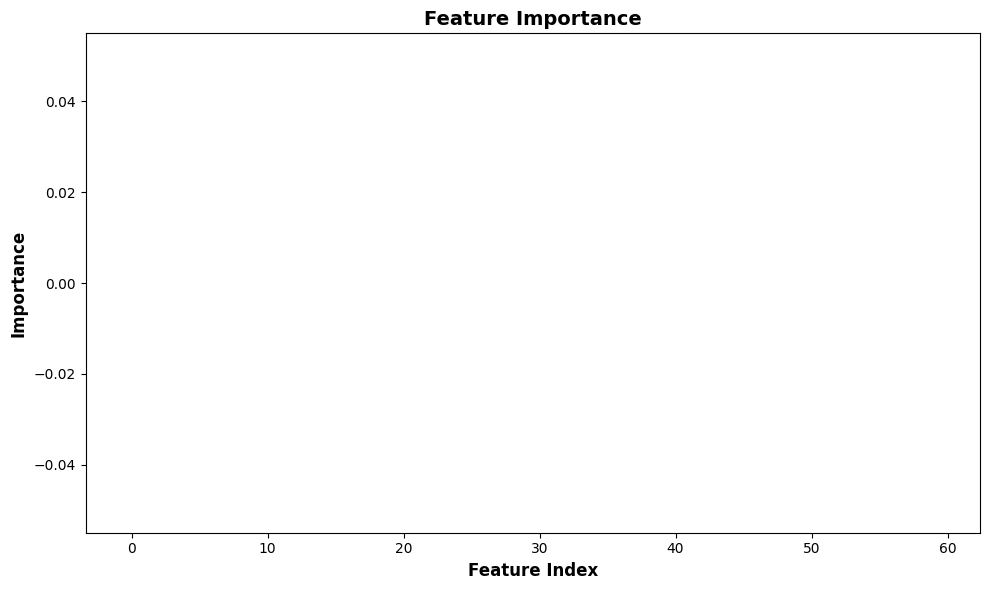


STEP 4: PREDICT SEGMENTATION

✓ Predicting segmentation for all images...
  Processing image 1/20...
✓ Extracting multi-scale features (σ=1 to 16)...
  Feature shape: (1024, 1024, 60)
  Features per pixel: 60
  Processing image 2/20...
✓ Extracting multi-scale features (σ=1 to 16)...
  Feature shape: (1024, 1024, 60)
  Features per pixel: 60
  Processing image 3/20...
✓ Extracting multi-scale features (σ=1 to 16)...
  Feature shape: (1024, 1024, 60)
  Features per pixel: 60
  Processing image 4/20...
✓ Extracting multi-scale features (σ=1 to 16)...
  Feature shape: (1024, 1024, 60)
  Features per pixel: 60
  Processing image 5/20...
✓ Extracting multi-scale features (σ=1 to 16)...
  Feature shape: (1024, 1024, 60)
  Features per pixel: 60
  Processing image 6/20...
✓ Extracting multi-scale features (σ=1 to 16)...
  Feature shape: (1024, 1024, 60)
  Features per pixel: 60
  Processing image 7/20...
✓ Extracting multi-scale features (σ=1 to 16)...
  Feature shape: (1024, 1024, 60)
  Fea

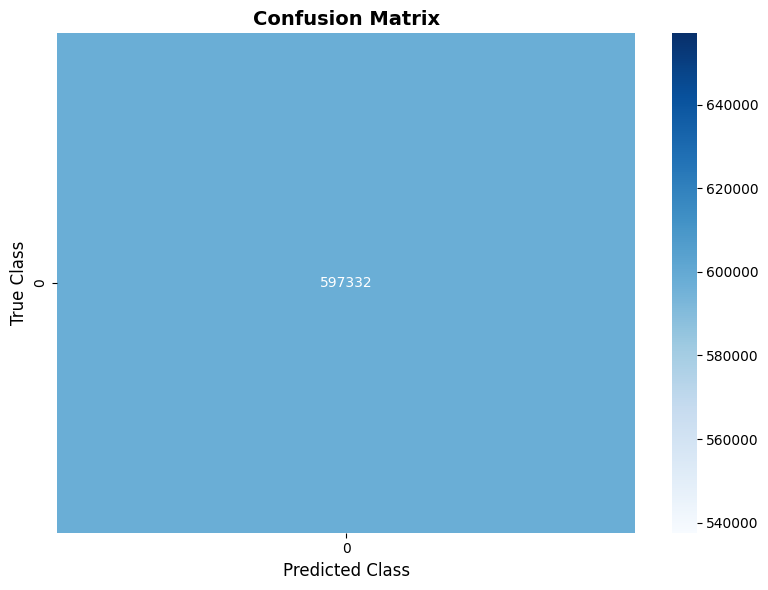


STEP 6: VISUALIZE RESULTS

✓ Visualizing segmentation results...


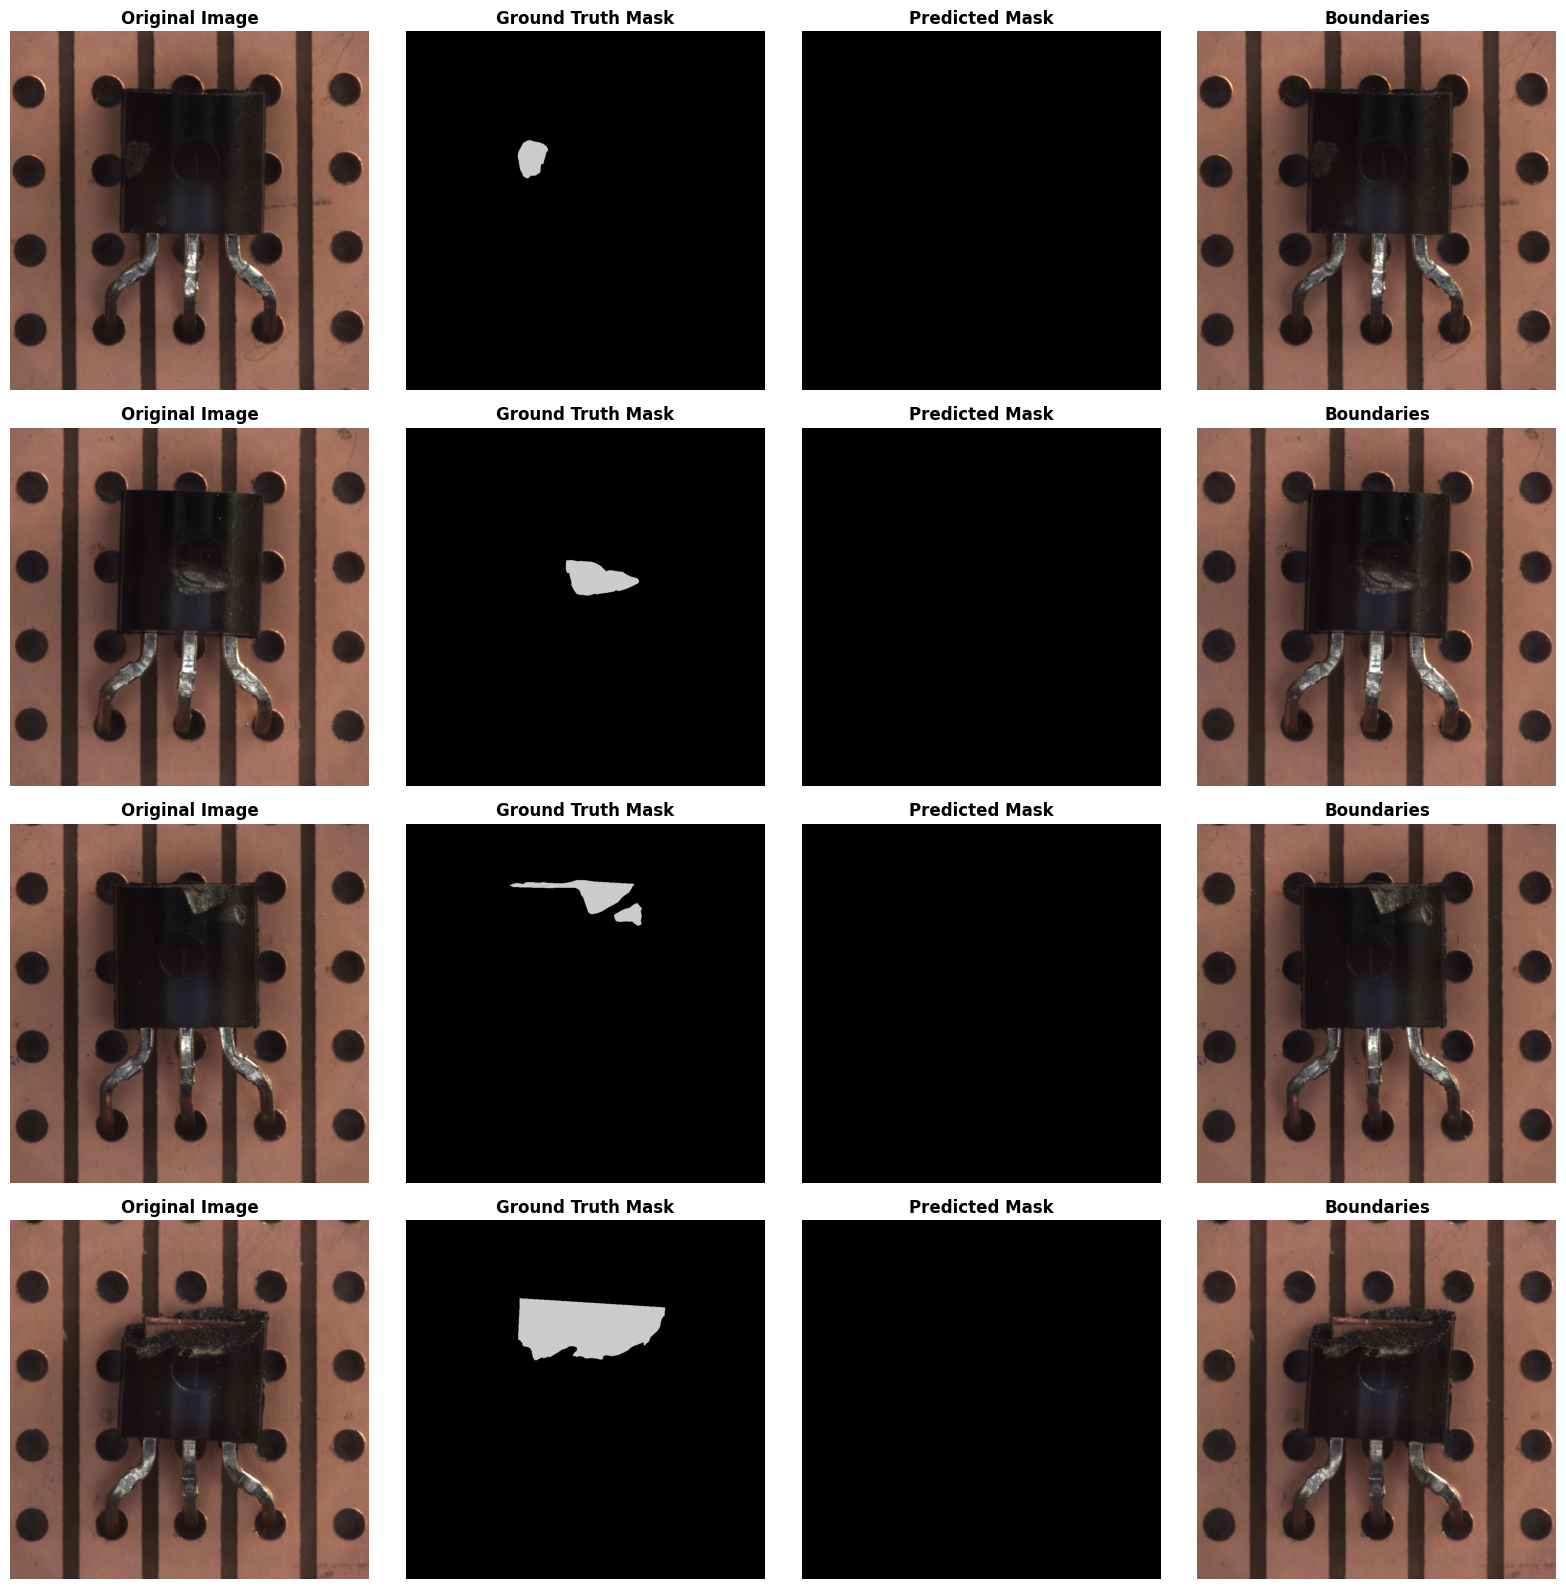


✓ Visualizing class separation for first image...


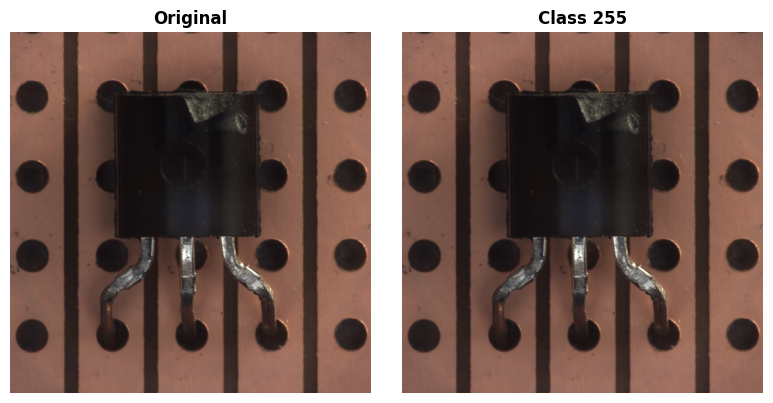


SEGMENTATION COMPLETE!

✓ Final Accuracy: 1.0000
✓ Model trained on 597332 pixels
✓ Segmented 20 images

✅ Your Random Forest segmentation model is ready!

To segment a new image:

        new_seg = segment_new_image(clf, 'path/to/new_image.jpg', 
                                     feature_method='multiscale')
        


In [ ]:
# ============================================
# RANDOM FOREST IMAGE SEGMENTATION
# Complete Code for Jupyter Lab (Local Machine)
# Works with Images + Masks
# ============================================

# Install libraries (run once in terminal)
# pip install scikit-learn scikit-image opencv-python matplotlib numpy scipy seaborn

import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import segmentation, feature, color, filters
from skimage.filters import gaussian, sobel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("RANDOM FOREST IMAGE SEGMENTATION - LOCAL VERSION")
print("="*70)

# ============================================
# 1. LOAD IMAGES AND MASKS FROM FOLDER
# ============================================

def load_segmentation_dataset(dataset_path, img_folder='images', mask_folder='masks'):
    """
    Load segmentation dataset from folder structure:

    dataset_path/
      ├── images/
      │   ├── img1.jpg
      │   ├── img2.jpg
      └── masks/
          ├── img1.png
          ├── img2.png

    Returns:
    - images: array of RGB images
    - masks: array of corresponding masks
    - filenames: list of filenames
    """
    print(f"\n✓ Loading dataset from: {dataset_path}")

    images_path = os.path.join(dataset_path, img_folder)
    masks_path = os.path.join(dataset_path, mask_folder)

    # Check if paths exist
    if not os.path.exists(images_path):
        raise ValueError(f"Images folder not found: {images_path}")
    if not os.path.exists(masks_path):
        raise ValueError(f"Masks folder not found: {masks_path}")

    # Get list of image files
    image_files = sorted([f for f in os.listdir(images_path)
                         if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))])

    print(f"  Found {len(image_files)} images")

    images = []
    masks = []
    filenames = []
    loaded_count = 0

    for img_file in image_files:
        # Create mask filename (same name, but .png)
        mask_file = os.path.splitext(img_file)[0] + '.png'

        img_path = os.path.join(images_path, img_file)
        mask_path = os.path.join(masks_path, mask_file)

        # Check if corresponding mask exists
        if not os.path.exists(mask_path):
            print(f"  ⚠ Warning: Mask not found for {img_file}, skipping...")
            continue

        try:
            # Load image (RGB)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Load mask (grayscale)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            # Ensure same size
            if img.shape[:2] != mask.shape:
                mask = cv2.resize(mask, (img.shape[1], img.shape[0]),
                                 interpolation=cv2.INTER_NEAREST)

            images.append(img)
            masks.append(mask)
            filenames.append(img_file)
            loaded_count += 1

        except Exception as e:
            print(f"  ✗ Error loading {img_file}: {e}")

    print(f"\n✓ Successfully loaded {loaded_count} image-mask pairs")

    if len(masks) > 0:
        unique_classes = np.unique(np.concatenate([m.ravel() for m in masks]))
        print(f"  Classes found in masks: {unique_classes}")

    return np.array(images), np.array(masks), filenames

def visualize_dataset_samples(images, masks, n_samples=4):
    """
    Visualize sample images with their masks
    """
    print(f"\n✓ Visualizing {n_samples} samples from dataset...")

    indices = np.random.choice(len(images), min(n_samples, len(images)), replace=False)

    fig, axes = plt.subplots(n_samples, 2, figsize=(10, 3*n_samples))
    if n_samples == 1:
        axes = axes.reshape(1, -1)

    for i, idx in enumerate(indices):
        # Original image
        axes[i, 0].imshow(images[idx])
        axes[i, 0].set_title(f'Image {idx}', fontweight='bold')
        axes[i, 0].axis('off')

        # Mask
        axes[i, 1].imshow(masks[idx], cmap='nipy_spectral')
        axes[i, 1].set_title(f'Mask {idx}', fontweight='bold')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# ============================================
# 2. FEATURE EXTRACTION FOR SEGMENTATION
# ============================================

def extract_multiscale_features(img, sigma_min=1, sigma_max=16):
    """
    Extract multi-scale features for each pixel

    Features include:
    - Intensity (color channels)
    - Edges (gradient magnitude)
    - Texture (at different scales)
    """
    print(f"\n✓ Extracting multi-scale features (σ={sigma_min} to {sigma_max})...")

    # Use scikit-image's built-in feature extraction
    features = feature.multiscale_basic_features(
        img,
        intensity=True,
        edges=True,
        texture=True,
        sigma_min=sigma_min,
        sigma_max=sigma_max,
        channel_axis=-1
    )

    print(f"  Feature shape: {features.shape}")
    print(f"  Features per pixel: {features.shape[2]}")

    return features

def extract_custom_features(img):
    """
    Extract custom features for segmentation
    """
    print("\n✓ Extracting custom features...")

    feature_list = []

    # Convert to different color spaces
    gray = color.rgb2gray(img)
    hsv = color.rgb2hsv(img)

    # Original RGB channels
    feature_list.append(img[:, :, 0])  # R
    feature_list.append(img[:, :, 1])  # G
    feature_list.append(img[:, :, 2])  # B

    # HSV channels
    feature_list.append(hsv[:, :, 0])  # Hue
    feature_list.append(hsv[:, :, 1])  # Saturation
    feature_list.append(hsv[:, :, 2])  # Value

    # Grayscale intensity
    feature_list.append(gray)

    # Edges (Sobel)
    edges = sobel(gray)
    feature_list.append(edges)

    # Texture features (Gaussian at different scales)
    for sigma in [1, 3, 5, 10]:
        blurred = gaussian(gray, sigma=sigma)
        feature_list.append(blurred)

    # Stack features
    features = np.stack(feature_list, axis=-1)

    print(f"  Feature shape: {features.shape}")
    print(f"  Features per pixel: {features.shape[2]}")

    return features

# ============================================
# 3. PREPARE DATA FOR TRAINING
# ============================================

def prepare_training_data(images, masks, feature_method='multiscale'):
    """
    Extract features from all images and prepare for training

    Returns:
    - X_all: All pixel features
    - y_all: All pixel labels
    - feature_list: List of feature arrays for each image
    """
    print("\n" + "="*70)
    print("PREPARING TRAINING DATA")
    print("="*70)

    X_all = []
    y_all = []
    feature_list = []

    print(f"\n✓ Processing {len(images)} images...")

    for i, (img, mask) in enumerate(zip(images, masks)):
        print(f"  Processing image {i+1}/{len(images)}...", end='\r')

        # Extract features
        if feature_method == 'multiscale':
            features = extract_multiscale_features(img)
        else:
            features = extract_custom_features(img)

        feature_list.append(features)

        # Flatten for training
        X = features.reshape(-1, features.shape[-1])
        y = mask.ravel()

        # Only use labeled pixels (mask > 0)
        labeled_mask = y > 0
        X_labeled = X[labeled_mask]
        y_labeled = y[labeled_mask]

        X_all.append(X_labeled)
        y_all.append(y_labeled)

    # Concatenate all data
    X_train = np.concatenate(X_all, axis=0)
    y_train = np.concatenate(y_all, axis=0)

    print(f"\n✓ Data preparation complete!")
    print(f"  Total labeled pixels: {len(X_train)}")
    print(f"  Classes: {np.unique(y_train)}")
    print(f"  Feature dimension: {X_train.shape[1]}")

    return X_train, y_train, feature_list

# ============================================
# 4. TRAIN RANDOM FOREST CLASSIFIER
# ============================================

def train_random_forest(X_train, y_train, n_estimators=100, max_depth=20):
    """
    Train Random Forest classifier for segmentation
    """
    print("\n" + "="*70)
    print("TRAINING RANDOM FOREST CLASSIFIER")
    print("="*70)

    print(f"\n✓ Training with {n_estimators} trees, max_depth={max_depth}...")

    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=10,
        min_samples_leaf=5,
        n_jobs=-1,
        random_state=42,
        verbose=0
    )

    clf.fit(X_train, y_train)

    print("  ✓ Training complete!")

    # Feature importance
    importances = clf.feature_importances_
    print(f"\n  Feature importance range: {importances.min():.4f} - {importances.max():.4f}")

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(importances)), importances)
    plt.xlabel('Feature Index', fontsize=12, fontweight='bold')
    plt.ylabel('Importance', fontsize=12, fontweight='bold')
    plt.title('Feature Importance', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    return clf

# ============================================
# 5. PREDICT SEGMENTATION
# ============================================

def predict_segmentation(clf, features):
    """
    Predict segmentation for an image

    Parameters:
    - clf: trained classifier
    - features: feature array (height, width, n_features)

    Returns:
    - segmentation: predicted mask (height, width)
    """
    # Flatten features
    X = features.reshape(-1, features.shape[-1])

    # Predict all pixels
    y_pred = clf.predict(X)

    # Reshape to image shape
    segmentation = y_pred.reshape(features.shape[:2])

    return segmentation

def predict_batch(clf, images, feature_method='multiscale'):
    """
    Predict segmentation for multiple images
    """
    print("\n✓ Predicting segmentation for all images...")

    segmentations = []

    for i, img in enumerate(images):
        print(f"  Processing image {i+1}/{len(images)}...", end='\r')

        # Extract features
        if feature_method == 'multiscale':
            features = extract_multiscale_features(img)
        else:
            features = extract_custom_features(img)

        # Predict
        seg = predict_segmentation(clf, features)
        segmentations.append(seg)

    print(f"\n  ✓ Segmentation complete!")

    return np.array(segmentations)

# ============================================
# 6. EVALUATE SEGMENTATION
# ============================================

def evaluate_segmentation(masks_true, masks_pred):
    """
    Evaluate segmentation accuracy
    """
    print("\n" + "="*70)
    print("EVALUATION METRICS")
    print("="*70)

    # Flatten all masks
    y_true_all = []
    y_pred_all = []

    for mask_true, mask_pred in zip(masks_true, masks_pred):
        # Only evaluate labeled pixels
        labeled_mask = mask_true > 0
        y_true_all.append(mask_true[labeled_mask])
        y_pred_all.append(mask_pred[labeled_mask])

    y_true = np.concatenate(y_true_all)
    y_pred = np.concatenate(y_pred_all)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    print(f"\n✓ Overall Pixel-wise Accuracy: {accuracy:.4f}")

    # Classification report
    print("\n✓ Classification Report:")
    print(classification_report(y_true, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
    plt.ylabel('True Class', fontsize=12)
    plt.xlabel('Predicted Class', fontsize=12)
    plt.tight_layout()
    plt.show()

    return accuracy, cm

# ============================================
# 7. VISUALIZE RESULTS
# ============================================

def visualize_segmentation_results(images, masks_true, masks_pred, n_samples=4):
    """
    Visualize segmentation results
    """
    print("\n✓ Visualizing segmentation results...")

    indices = np.random.choice(len(images), min(n_samples, len(images)), replace=False)

    fig, axes = plt.subplots(n_samples, 4, figsize=(16, 4*n_samples))
    if n_samples == 1:
        axes = axes.reshape(1, -1)

    for i, idx in enumerate(indices):
        # Original image
        axes[i, 0].imshow(images[idx])
        axes[i, 0].set_title('Original Image', fontweight='bold')
        axes[i, 0].axis('off')

        # True mask
        axes[i, 1].imshow(masks_true[idx], cmap='nipy_spectral')
        axes[i, 1].set_title('Ground Truth Mask', fontweight='bold')
        axes[i, 1].axis('off')

        # Predicted mask
        axes[i, 2].imshow(masks_pred[idx], cmap='nipy_spectral')
        axes[i, 2].set_title('Predicted Mask', fontweight='bold')
        axes[i, 2].axis('off')

        # Overlay
        axes[i, 3].imshow(segmentation.mark_boundaries(images[idx], masks_pred[idx], mode='thick'))
        axes[i, 3].set_title('Boundaries', fontweight='bold')
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()

def visualize_each_class(img, segmentation, class_names=None):
    """
    Visualize each segmented class separately
    """
    classes = np.unique(segmentation)
    classes = classes[classes > 0]  # Exclude background
    n_classes = len(classes)

    fig, axes = plt.subplots(1, n_classes + 1, figsize=(4 * (n_classes + 1), 4))
    if n_classes == 0:
        print("No classes found in segmentation!")
        return

    # Original
    axes[0].imshow(img)
    axes[0].set_title('Original', fontweight='bold')
    axes[0].axis('off')

    # Each class
    for i, cls in enumerate(classes):
        mask = (segmentation == cls)
        masked_img = img.copy()
        masked_img[~mask] = 0

        if class_names and cls-1 < len(class_names):
            title = f'{class_names[cls-1]}'
        else:
            title = f'Class {cls}'

        axes[i + 1].imshow(masked_img)
        axes[i + 1].set_title(title, fontweight='bold')
        axes[i + 1].axis('off')

    plt.tight_layout()
    plt.show()

# ============================================
# 8. COMPLETE PIPELINE
# ============================================

def run_rf_segmentation_pipeline(dataset_path, feature_method='multiscale',
                                  n_estimators=100, max_depth=20):
    """
    Complete Random Forest segmentation pipeline

    Parameters:
    - dataset_path: Path to dataset folder (with 'images' and 'masks' subfolders)
    - feature_method: 'multiscale' or 'custom'
    - n_estimators: Number of trees in Random Forest
    - max_depth: Maximum depth of trees
    """
    print("\n" + "#"*70)
    print("# RANDOM FOREST IMAGE SEGMENTATION PIPELINE")
    print("#"*70)

    # Step 1: Load dataset
    print("\n" + "="*70)
    print("STEP 1: LOAD DATASET")
    print("="*70)

    images, masks, filenames = load_segmentation_dataset(dataset_path)

    if len(images) == 0:
        print("✗ No images loaded! Check your dataset path.")
        return None

    # Visualize samples
    visualize_dataset_samples(images, masks, n_samples=min(4, len(images)))

    # Step 2: Prepare training data
    X_train, y_train, feature_list = prepare_training_data(
        images, masks, feature_method=feature_method
    )

    # Step 3: Train Random Forest
    clf = train_random_forest(X_train, y_train,
                              n_estimators=n_estimators,
                              max_depth=max_depth)

    # Step 4: Predict on all images
    print("\n" + "="*70)
    print("STEP 4: PREDICT SEGMENTATION")
    print("="*70)

    masks_pred = predict_batch(clf, images, feature_method=feature_method)

    # Step 5: Evaluate
    accuracy, cm = evaluate_segmentation(masks, masks_pred)

    # Step 6: Visualize results
    print("\n" + "="*70)
    print("STEP 6: VISUALIZE RESULTS")
    print("="*70)

    visualize_segmentation_results(images, masks, masks_pred,
                                   n_samples=min(4, len(images)))

    # Visualize class separation for first image
    if len(images) > 0:
        print("\n✓ Visualizing class separation for first image...")
        visualize_each_class(images[0], masks_pred[0])

    print("\n" + "="*70)
    print("SEGMENTATION COMPLETE!")
    print("="*70)
    print(f"\n✓ Final Accuracy: {accuracy:.4f}")
    print(f"✓ Model trained on {len(X_train)} pixels")
    print(f"✓ Segmented {len(images)} images")

    return clf, images, masks, masks_pred, feature_list

# ============================================
# 9. SEGMENT NEW IMAGE
# ============================================

def segment_new_image(clf, image_path, feature_method='multiscale'):
    """
    Segment a new image using trained model
    """
    print(f"\n✓ Segmenting new image: {image_path}")

    # Load image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Extract features
    if feature_method == 'multiscale':
        features = extract_multiscale_features(img)
    else:
        features = extract_custom_features(img)

    # Predict
    segmentation = predict_segmentation(clf, features)

    # Visualize
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(img)
    axes[0].set_title('Original Image', fontweight='bold')
    axes[0].axis('off')

    axes[1].imshow(segmentation, cmap='nipy_spectral')
    axes[1].set_title('Segmentation', fontweight='bold')
    axes[1].axis('off')

    axes[2].imshow(segmentation.mark_boundaries(img, segmentation, mode='thick'))
    axes[2].set_title('Boundaries', fontweight='bold')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    return segmentation

# ============================================
# MAIN EXECUTION
# ============================================

if __name__ == "__main__":

    print("\n" + "#"*70)
    print("# RANDOM FOREST IMAGE SEGMENTATION")
    print("#"*70)

    # Input your dataset path
    print("\nEnter your dataset path:")
    print("Example (Windows): C:\\Users\\YourName\\Desktop\\my_dataset")
    print("Example (Mac/Linux): /home/yourname/Desktop/my_dataset")
    print("\nYour dataset should have this structure:")
    print("  my_dataset/")
    print("    ├── images/")
    print("    │   ├── img1.jpg")
    print("    │   ├── img2.jpg")
    print("    └── masks/")
    print("        ├── img1.png")
    print("        ├── img2.png")

    dataset_path = input("\nDataset path: ").strip()

    # Remove quotes if user copied path with quotes
    dataset_path = dataset_path.strip('"').strip("'")

    # Check if path exists
    if not os.path.exists(dataset_path):
        print(f"\n✗ Error: Path not found: {dataset_path}")
        print("Please check the path and try again.")
    else:
        # Run pipeline
        clf, images, masks_true, masks_pred, features = run_rf_segmentation_pipeline(
            dataset_path=dataset_path,
            feature_method='multiscale',  # or 'custom'
            n_estimators=100,
            max_depth=20
        )

        print("\n✅ Your Random Forest segmentation model is ready!")
        print("\nTo segment a new image:")
        print("""
        new_seg = segment_new_image(clf, 'path/to/new_image.jpg',
                                     feature_method='multiscale')
        """)


SVM IMAGE SEGMENTATION - GOOGLE COLAB

######################################################################
# SVM IMAGE SEGMENTATION - GOOGLE COLAB
######################################################################

STEP 1: CHOOSE DATA LOADING METHOD

Select one option:
1. Upload ZIP file (recommended for medium datasets)
2. Mount Google Drive (recommended for large datasets)
3. Enter folder path directly (if already uploaded)

Enter your choice (1/2/3): 3

Enter full path to your dataset folder: /content/drive/MyDrive/Data_2

✓ Dataset path confirmed: /content/drive/MyDrive/Data_2

TRAINING OPTIONS

Use hyperparameter tuning (GridSearchCV)?
  - Yes: Better accuracy, but MUCH slower
  - No: Fast training with good default parameters

Use tuning? (y/n) [n]: n

Pixel sampling fraction (for SVM training speed):
  - 0.05 (5%): Very fast, lower accuracy
  - 0.1 (10%): Balanced (RECOMMENDED)
  - 0.2 (20%): Slower, higher accuracy

Sample fraction [0.1]: 0.1

###########################

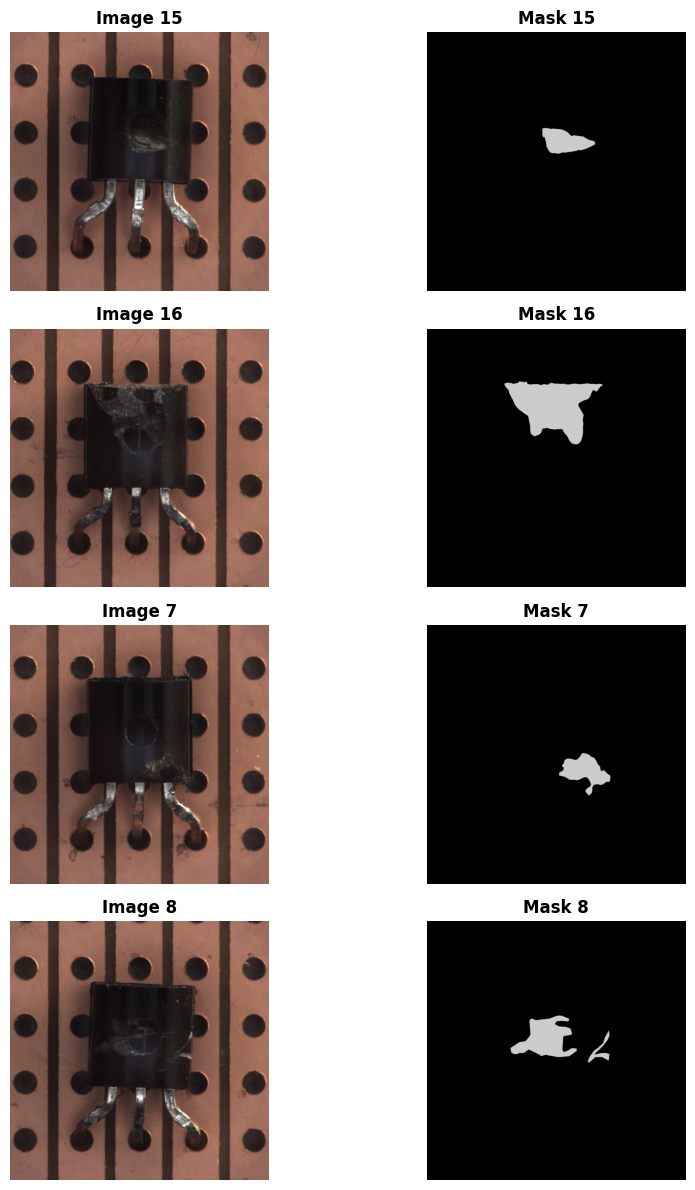


PREPARING TRAINING DATA

✓ Processing 20 images...
  Using 10% of labeled pixels for training (SVM optimization)

✓ Data preparation complete!
  Total training pixels: 59724
  Classes: [255]
  Feature dimension: 60

TRAINING SVM CLASSIFIER

✓ Training SVM with RBF kernel...
  Parameters: C=10, gamma=scale


ValueError: The number of classes has to be greater than one; got 1 class

In [ ]:
# ============================================
# SVM IMAGE SEGMENTATION
# Complete Code for Google Colab
# Works with Images + Masks
# ============================================

# Install libraries
!pip install scikit-learn scikit-image opencv-python matplotlib numpy scipy seaborn -q

import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import segmentation, feature, color, filters
from skimage.filters import gaussian, sobel
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import os
import zipfile
from google.colab import files, drive
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("SVM IMAGE SEGMENTATION - GOOGLE COLAB")
print("="*70)

# ============================================
# DATA LOADING OPTIONS FOR COLAB
# ============================================

def mount_google_drive():
    """
    Mount Google Drive to access your dataset
    """
    print("\n✓ Mounting Google Drive...")
    drive.mount('/content/drive')
    print("✓ Google Drive mounted successfully!")
    print("\nYour dataset path will be: /content/drive/MyDrive/your_dataset_folder")
    return '/content/drive/MyDrive/'

def upload_and_extract_zip():
    """
    Upload a zip file containing your image dataset

    Expected folder structure inside zip:
    dataset.zip
      ├── images/
      │   ├── image1.jpg
      │   ├── image2.jpg
      └── masks/
          ├── image1.png
          ├── image2.png
    """
    print("\n✓ Upload your dataset ZIP file...")
    uploaded = files.upload()

    zip_filename = list(uploaded.keys())[0]
    print(f"\n✓ Extracting {zip_filename}...")

    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall('dataset')

    print("✓ Extraction complete!")

    # Find the extracted folder
    extracted_folders = os.listdir('dataset')
    if len(extracted_folders) == 1:
        dataset_path = os.path.join('dataset', extracted_folders[0])
    else:
        dataset_path = 'dataset'

    return dataset_path

# ============================================
# 1. LOAD IMAGES AND MASKS FROM FOLDER
# ============================================

def load_segmentation_dataset(dataset_path, img_folder='images', mask_folder='masks'):
    """
    Load segmentation dataset from folder structure:

    dataset_path/
      ├── images/
      │   ├── img1.jpg
      │   ├── img2.jpg
      └── masks/
          ├── img1.png
          ├── img2.png

    Returns:
    - images: array of RGB images
    - masks: array of corresponding masks
    - filenames: list of filenames
    """
    print(f"\n✓ Loading dataset from: {dataset_path}")

    images_path = os.path.join(dataset_path, img_folder)
    masks_path = os.path.join(dataset_path, mask_folder)

    # Check if paths exist
    if not os.path.exists(images_path):
        raise ValueError(f"Images folder not found: {images_path}")
    if not os.path.exists(masks_path):
        raise ValueError(f"Masks folder not found: {masks_path}")

    # Get list of image files
    image_files = sorted([f for f in os.listdir(images_path)
                         if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))])

    print(f"  Found {len(image_files)} images")

    images = []
    masks = []
    filenames = []
    loaded_count = 0

    for img_file in image_files:
        # Create mask filename (same name, but .png)
        mask_file = os.path.splitext(img_file)[0] + '.png'

        img_path = os.path.join(images_path, img_file)
        mask_path = os.path.join(masks_path, mask_file)

        # Check if corresponding mask exists
        if not os.path.exists(mask_path):
            print(f"  ⚠ Warning: Mask not found for {img_file}, skipping...")
            continue

        try:
            # Load image (RGB)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Load mask (grayscale)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            # Ensure same size
            if img.shape[:2] != mask.shape:
                mask = cv2.resize(mask, (img.shape[1], img.shape[0]),
                                 interpolation=cv2.INTER_NEAREST)

            images.append(img)
            masks.append(mask)
            filenames.append(img_file)
            loaded_count += 1

        except Exception as e:
            print(f"  ✗ Error loading {img_file}: {e}")

    print(f"\n✓ Successfully loaded {loaded_count} image-mask pairs")

    if len(masks) > 0:
        unique_classes = np.unique(np.concatenate([m.ravel() for m in masks]))
        print(f"  Classes found in masks: {unique_classes}")

    return np.array(images), np.array(masks), filenames

def visualize_dataset_samples(images, masks, n_samples=4):
    """
    Visualize sample images with their masks
    """
    print(f"\n✓ Visualizing {n_samples} samples from dataset...")

    indices = np.random.choice(len(images), min(n_samples, len(images)), replace=False)

    fig, axes = plt.subplots(n_samples, 2, figsize=(10, 3*n_samples))
    if n_samples == 1:
        axes = axes.reshape(1, -1)

    for i, idx in enumerate(indices):
        # Original image
        axes[i, 0].imshow(images[idx])
        axes[i, 0].set_title(f'Image {idx}', fontweight='bold')
        axes[i, 0].axis('off')

        # Mask
        axes[i, 1].imshow(masks[idx], cmap='nipy_spectral')
        axes[i, 1].set_title(f'Mask {idx}', fontweight='bold')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# ============================================
# 2. FEATURE EXTRACTION FOR SEGMENTATION
# ============================================

def extract_multiscale_features(img, sigma_min=1, sigma_max=16):
    """
    Extract multi-scale features for each pixel

    Features include:
    - Intensity (color channels)
    - Edges (gradient magnitude)
    - Texture (at different scales)
    """
    # Use scikit-image's built-in feature extraction
    features = feature.multiscale_basic_features(
        img,
        intensity=True,
        edges=True,
        texture=True,
        sigma_min=sigma_min,
        sigma_max=sigma_max,
        channel_axis=-1
    )

    return features

def extract_custom_features(img):
    """
    Extract custom features for segmentation
    """
    feature_list = []

    # Convert to different color spaces
    gray = color.rgb2gray(img)
    hsv = color.rgb2hsv(img)

    # Original RGB channels
    feature_list.append(img[:, :, 0])  # R
    feature_list.append(img[:, :, 1])  # G
    feature_list.append(img[:, :, 2])  # B

    # HSV channels
    feature_list.append(hsv[:, :, 0])  # Hue
    feature_list.append(hsv[:, :, 1])  # Saturation
    feature_list.append(hsv[:, :, 2])  # Value

    # Grayscale intensity
    feature_list.append(gray)

    # Edges (Sobel)
    edges = sobel(gray)
    feature_list.append(edges)

    # Texture features (Gaussian at different scales)
    for sigma in [1, 3, 5, 10]:
        blurred = gaussian(gray, sigma=sigma)
        feature_list.append(blurred)

    # Stack features
    features = np.stack(feature_list, axis=-1)

    return features

# ============================================
# 3. PREPARE DATA FOR TRAINING
# ============================================

def prepare_training_data(images, masks, feature_method='multiscale', sample_fraction=0.1):
    """
    Extract features from all images and prepare for training

    For SVM, we subsample pixels to reduce training time

    Parameters:
    - sample_fraction: fraction of labeled pixels to use (0.1 = 10%)

    Returns:
    - X_train: Training pixel features
    - y_train: Training pixel labels
    - feature_list: List of feature arrays for each image
    """
    print("\n" + "="*70)
    print("PREPARING TRAINING DATA")
    print("="*70)

    X_all = []
    y_all = []
    feature_list = []

    print(f"\n✓ Processing {len(images)} images...")
    print(f"  Using {sample_fraction*100:.0f}% of labeled pixels for training (SVM optimization)")

    for i, (img, mask) in enumerate(zip(images, masks)):
        print(f"  Processing image {i+1}/{len(images)}...", end='\r')

        # Extract features
        if feature_method == 'multiscale':
            features = extract_multiscale_features(img)
        else:
            features = extract_custom_features(img)

        feature_list.append(features)

        # Flatten for training
        X = features.reshape(-1, features.shape[-1])
        y = mask.ravel()

        # Only use labeled pixels (mask > 0)
        labeled_mask = y > 0
        X_labeled = X[labeled_mask]
        y_labeled = y[labeled_mask]

        # Subsample for SVM (to reduce training time)
        n_samples = int(len(X_labeled) * sample_fraction)
        if n_samples > 0:
            indices = np.random.choice(len(X_labeled), n_samples, replace=False)
            X_sampled = X_labeled[indices]
            y_sampled = y_labeled[indices]

            X_all.append(X_sampled)
            y_all.append(y_sampled)

    # Concatenate all data
    X_train = np.concatenate(X_all, axis=0)
    y_train = np.concatenate(y_all, axis=0)

    print(f"\n✓ Data preparation complete!")
    print(f"  Total training pixels: {len(X_train)}")
    print(f"  Classes: {np.unique(y_train)}")
    print(f"  Feature dimension: {X_train.shape[1]}")

    return X_train, y_train, feature_list

# ============================================
# 4. TRAIN SVM CLASSIFIER
# ============================================

def train_svm_basic(X_train, y_train, kernel='rbf', C=10, gamma='scale'):
    """
    Train basic SVM classifier for segmentation
    """
    print("\n" + "="*70)
    print("TRAINING SVM CLASSIFIER")
    print("="*70)

    print(f"\n✓ Training SVM with {kernel.upper()} kernel...")
    print(f"  Parameters: C={C}, gamma={gamma}")

    # Scale features (critical for SVM)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Train SVM
    svm = SVC(
        kernel=kernel,
        C=C,
        gamma=gamma,
        random_state=42,
        verbose=False
    )

    svm.fit(X_train_scaled, y_train)

    print("  ✓ Training complete!")
    print(f"  Number of support vectors: {svm.n_support_.sum()}")

    return svm, scaler

def train_svm_with_tuning(X_train, y_train, cv=3):
    """
    Train SVM with hyperparameter tuning using GridSearchCV
    Note: This can be slow for large datasets
    """
    print("\n" + "="*70)
    print("TRAINING SVM WITH HYPERPARAMETER TUNING")
    print("="*70)

    print(f"\n✓ Training SVM with GridSearchCV (this may take a while)...")

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Define parameter grid
    param_grid = {
        'C': [1, 10, 100],
        'gamma': ['scale', 0.01, 0.1],
        'kernel': ['rbf', 'linear']
    }

    # Create GridSearchCV
    svm = SVC(random_state=42)
    grid_search = GridSearchCV(
        estimator=svm,
        param_grid=param_grid,
        cv=cv,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train_scaled, y_train)

    print(f"\n  ✓ Grid Search Complete!")
    print(f"  Best Parameters: {grid_search.best_params_}")
    print(f"  Best Cross-Validation Score: {grid_search.best_score_:.4f}")

    return grid_search.best_estimator_, scaler

# ============================================
# 5. PREDICT SEGMENTATION
# ============================================

def predict_segmentation(svm, scaler, features):
    """
    Predict segmentation for an image

    Parameters:
    - svm: trained SVM classifier
    - scaler: fitted StandardScaler
    - features: feature array (height, width, n_features)

    Returns:
    - segmentation: predicted mask (height, width)
    """
    # Flatten features
    X = features.reshape(-1, features.shape[-1])

    # Scale features
    X_scaled = scaler.transform(X)

    # Predict all pixels
    y_pred = svm.predict(X_scaled)

    # Reshape to image shape
    segmentation = y_pred.reshape(features.shape[:2])

    return segmentation

def predict_batch(svm, scaler, images, feature_method='multiscale'):
    """
    Predict segmentation for multiple images
    """
    print("\n✓ Predicting segmentation for all images...")

    segmentations = []

    for i, img in enumerate(images):
        print(f"  Processing image {i+1}/{len(images)}...", end='\r')

        # Extract features
        if feature_method == 'multiscale':
            features = extract_multiscale_features(img)
        else:
            features = extract_custom_features(img)

        # Predict
        seg = predict_segmentation(svm, scaler, features)
        segmentations.append(seg)

    print(f"\n  ✓ Segmentation complete!")

    return np.array(segmentations)

# ============================================
# 6. EVALUATE SEGMENTATION
# ============================================

def evaluate_segmentation(masks_true, masks_pred):
    """
    Evaluate segmentation accuracy
    """
    print("\n" + "="*70)
    print("EVALUATION METRICS")
    print("="*70)

    # Flatten all masks
    y_true_all = []
    y_pred_all = []

    for mask_true, mask_pred in zip(masks_true, masks_pred):
        # Only evaluate labeled pixels
        labeled_mask = mask_true > 0
        y_true_all.append(mask_true[labeled_mask])
        y_pred_all.append(mask_pred[labeled_mask])

    y_true = np.concatenate(y_true_all)
    y_pred = np.concatenate(y_pred_all)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    print(f"\n✓ Overall Pixel-wise Accuracy: {accuracy:.4f}")

    # Classification report
    print("\n✓ Classification Report:")
    print(classification_report(y_true, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
    plt.ylabel('True Class', fontsize=12)
    plt.xlabel('Predicted Class', fontsize=12)
    plt.tight_layout()
    plt.show()

    return accuracy, cm

# ============================================
# 7. VISUALIZE RESULTS
# ============================================

def visualize_segmentation_results(images, masks_true, masks_pred, n_samples=4):
    """
    Visualize segmentation results
    """
    print("\n✓ Visualizing segmentation results...")

    indices = np.random.choice(len(images), min(n_samples, len(images)), replace=False)

    fig, axes = plt.subplots(n_samples, 4, figsize=(16, 4*n_samples))
    if n_samples == 1:
        axes = axes.reshape(1, -1)

    for i, idx in enumerate(indices):
        # Original image
        axes[i, 0].imshow(images[idx])
        axes[i, 0].set_title('Original Image', fontweight='bold')
        axes[i, 0].axis('off')

        # True mask
        axes[i, 1].imshow(masks_true[idx], cmap='nipy_spectral')
        axes[i, 1].set_title('Ground Truth Mask', fontweight='bold')
        axes[i, 1].axis('off')

        # Predicted mask
        axes[i, 2].imshow(masks_pred[idx], cmap='nipy_spectral')
        axes[i, 2].set_title('Predicted Mask', fontweight='bold')
        axes[i, 2].axis('off')

        # Overlay
        axes[i, 3].imshow(segmentation.mark_boundaries(images[idx], masks_pred[idx], mode='thick'))
        axes[i, 3].set_title('Boundaries', fontweight='bold')
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()

def visualize_each_class(img, segmentation, class_names=None):
    """
    Visualize each segmented class separately
    """
    classes = np.unique(segmentation)
    classes = classes[classes > 0]  # Exclude background
    n_classes = len(classes)

    if n_classes == 0:
        print("No classes found in segmentation!")
        return

    fig, axes = plt.subplots(1, n_classes + 1, figsize=(4 * (n_classes + 1), 4))

    # Original
    axes[0].imshow(img)
    axes[0].set_title('Original', fontweight='bold')
    axes[0].axis('off')

    # Each class
    for i, cls in enumerate(classes):
        mask = (segmentation == cls)
        masked_img = img.copy()
        masked_img[~mask] = 0

        if class_names and cls-1 < len(class_names):
            title = f'{class_names[cls-1]}'
        else:
            title = f'Class {cls}'

        axes[i + 1].imshow(masked_img)
        axes[i + 1].set_title(title, fontweight='bold')
        axes[i + 1].axis('off')

    plt.tight_layout()
    plt.show()

# ============================================
# 8. COMPLETE PIPELINE
# ============================================

def run_svm_segmentation_pipeline(dataset_path, feature_method='multiscale',
                                   use_tuning=False, sample_fraction=0.1):
    """
    Complete SVM segmentation pipeline

    Parameters:
    - dataset_path: Path to dataset folder (with 'images' and 'masks' subfolders)
    - feature_method: 'multiscale' or 'custom'
    - use_tuning: Whether to use GridSearchCV (slower but better results)
    - sample_fraction: Fraction of pixels to use for training (reduce for speed)
    """
    print("\n" + "#"*70)
    print("# SVM IMAGE SEGMENTATION PIPELINE")
    print("#"*70)

    # Step 1: Load dataset
    print("\n" + "="*70)
    print("STEP 1: LOAD DATASET")
    print("="*70)

    images, masks, filenames = load_segmentation_dataset(dataset_path)

    if len(images) == 0:
        print("✗ No images loaded! Check your dataset path.")
        return None

    # Visualize samples
    visualize_dataset_samples(images, masks, n_samples=min(4, len(images)))

    # Step 2: Prepare training data
    X_train, y_train, feature_list = prepare_training_data(
        images, masks, feature_method=feature_method, sample_fraction=sample_fraction
    )

    # Step 3: Train SVM
    if use_tuning:
        svm, scaler = train_svm_with_tuning(X_train, y_train, cv=3)
    else:
        svm, scaler = train_svm_basic(X_train, y_train, kernel='rbf', C=10, gamma='scale')

    # Step 4: Predict on all images
    print("\n" + "="*70)
    print("STEP 4: PREDICT SEGMENTATION")
    print("="*70)

    masks_pred = predict_batch(svm, scaler, images, feature_method=feature_method)

    # Step 5: Evaluate
    accuracy, cm = evaluate_segmentation(masks, masks_pred)

    # Step 6: Visualize results
    print("\n" + "="*70)
    print("STEP 6: VISUALIZE RESULTS")
    print("="*70)

    visualize_segmentation_results(images, masks, masks_pred,
                                   n_samples=min(4, len(images)))

    # Visualize class separation for first image
    if len(images) > 0:
        print("\n✓ Visualizing class separation for first image...")
        visualize_each_class(images[0], masks_pred[0])

    print("\n" + "="*70)
    print("SEGMENTATION COMPLETE!")
    print("="*70)
    print(f"\n✓ Final Accuracy: {accuracy:.4f}")
    print(f"✓ Model trained on {len(X_train)} pixels")
    print(f"✓ Segmented {len(images)} images")

    return svm, scaler, images, masks, masks_pred, feature_list

# ============================================
# 9. SEGMENT NEW IMAGE
# ============================================

def segment_new_image(svm, scaler, image_path, feature_method='multiscale'):
    """
    Segment a new image using trained model
    """
    print(f"\n✓ Segmenting new image: {image_path}")

    # Load image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Extract features
    if feature_method == 'multiscale':
        features = extract_multiscale_features(img)
    else:
        features = extract_custom_features(img)

    # Predict
    segmentation = predict_segmentation(svm, scaler, features)

    # Visualize
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(img)
    axes[0].set_title('Original Image', fontweight='bold')
    axes[0].axis('off')

    axes[1].imshow(segmentation, cmap='nipy_spectral')
    axes[1].set_title('Segmentation', fontweight='bold')
    axes[1].axis('off')

    axes[2].imshow(segmentation.mark_boundaries(img, segmentation, mode='thick'))
    axes[2].set_title('Boundaries', fontweight='bold')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    return segmentation

# ============================================
# MAIN EXECUTION - COLAB VERSION
# ============================================

print("\n" + "#"*70)
print("# SVM IMAGE SEGMENTATION - GOOGLE COLAB")
print("#"*70)

print("\n" + "="*70)
print("STEP 1: CHOOSE DATA LOADING METHOD")
print("="*70)
print("\nSelect one option:")
print("1. Upload ZIP file (recommended for medium datasets)")
print("2. Mount Google Drive (recommended for large datasets)")
print("3. Enter folder path directly (if already uploaded)")

choice = input("\nEnter your choice (1/2/3): ").strip()

if choice == '1':
    # Upload ZIP
    dataset_path = upload_and_extract_zip()
elif choice == '2':
    # Mount Google Drive
    drive_path = mount_google_drive()
    folder_name = input("\nEnter your dataset folder name in Google Drive: ").strip()
    dataset_path = os.path.join(drive_path, folder_name)
elif choice == '3':
    # Direct path
    dataset_path = input("\nEnter full path to your dataset folder: ").strip()
else:
    print("Invalid choice. Using default path: /content/dataset")
    dataset_path = '/content/dataset'

# Check if path exists
if not os.path.exists(dataset_path):
    print(f"\n✗ Error: Path not found: {dataset_path}")
    print("Please check the path and try again.")
else:
    print(f"\n✓ Dataset path confirmed: {dataset_path}")

    # Ask about hyperparameter tuning
    print("\n" + "="*70)
    print("TRAINING OPTIONS")
    print("="*70)
    print("\nUse hyperparameter tuning (GridSearchCV)?")
    print("  - Yes: Better accuracy, but MUCH slower")
    print("  - No: Fast training with good default parameters")

    use_tuning_input = input("\nUse tuning? (y/n) [n]: ").strip().lower()
    use_tuning = (use_tuning_input == 'y')

    # Ask about sampling fraction
    print("\nPixel sampling fraction (for SVM training speed):")
    print("  - 0.05 (5%): Very fast, lower accuracy")
    print("  - 0.1 (10%): Balanced (RECOMMENDED)")
    print("  - 0.2 (20%): Slower, higher accuracy")

    sample_input = input("\nSample fraction [0.1]: ").strip()
    sample_fraction = float(sample_input) if sample_input else 0.1

    # Run pipeline
    svm, scaler, images, masks_true, masks_pred, features = run_svm_segmentation_pipeline(
        dataset_path=dataset_path,
        feature_method='multiscale',  # or 'custom'
        use_tuning=use_tuning,
        sample_fraction=sample_fraction
    )

    print("\n✅ Your SVM segmentation model is ready!")
    print("\nTo segment a new image:")
    print("""
    # Upload new image
    uploaded = files.upload()
    new_image_path = list(uploaded.keys())[0]

    # Segment
    new_seg = segment_new_image(svm, scaler, new_image_path, feature_method='multiscale')
    """)


In [ ]:
# ============================================
# FIXED: SVM IMAGE SEGMENTATION
# With Proper Mask Validation
# ============================================

# Install libraries
!pip install scikit-learn scikit-image opencv-python matplotlib numpy scipy seaborn -q

import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import segmentation, feature, color, filters
from skimage.filters import gaussian, sobel
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import os
import zipfile
from google.colab import files, drive
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("SVM IMAGE SEGMENTATION - GOOGLE COLAB (FIXED)")
print("="*70)

# ============================================
# DATA LOADING OPTIONS FOR COLAB
# ============================================

def mount_google_drive():
    """Mount Google Drive"""
    print("\n✓ Mounting Google Drive...")
    drive.mount('/content/drive')
    print("✓ Google Drive mounted successfully!")
    return '/content/drive/MyDrive/'

def upload_and_extract_zip():
    """Upload and extract ZIP file"""
    print("\n✓ Upload your dataset ZIP file...")
    uploaded = files.upload()

    zip_filename = list(uploaded.keys())[0]
    print(f"\n✓ Extracting {zip_filename}...")

    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall('dataset')

    print("✓ Extraction complete!")

    extracted_folders = os.listdir('dataset')
    if len(extracted_folders) == 1:
        dataset_path = os.path.join('dataset', extracted_folders[0])
    else:
        dataset_path = 'dataset'

    return dataset_path

# ============================================
# MASK VALIDATION AND INSPECTION
# ============================================

def inspect_mask(mask, filename=""):
    """
    Inspect mask to understand its structure
    """
    unique_values = np.unique(mask)
    print(f"\n  Mask: {filename}")
    print(f"    Shape: {mask.shape}")
    print(f"    Data type: {mask.dtype}")
    print(f"    Min value: {mask.min()}, Max value: {mask.max()}")
    print(f"    Unique values: {unique_values}")
    print(f"    Value counts:")
    for val in unique_values:
        count = np.sum(mask == val)
        percentage = (count / mask.size) * 100
        print(f"      Value {val}: {count} pixels ({percentage:.2f}%)")

    return unique_values

def validate_masks(masks, filenames):
    """
    Validate that masks contain multiple classes
    """
    print("\n" + "="*70)
    print("VALIDATING MASKS")
    print("="*70)

    all_classes = set()
    valid_masks = []

    for i, (mask, filename) in enumerate(zip(masks, filenames)):
        unique_values = np.unique(mask)

        # Get non-background classes (assuming 0 is background)
        non_bg_classes = unique_values[unique_values > 0]

        if len(non_bg_classes) == 0:
            print(f"\n⚠ WARNING: {filename} has NO labeled pixels (all background)")
        elif len(non_bg_classes) == 1:
            print(f"\n⚠ WARNING: {filename} has only 1 class: {non_bg_classes}")
        else:
            print(f"\n✓ {filename}: {len(non_bg_classes)} classes found: {non_bg_classes}")
            valid_masks.append(i)

        all_classes.update(non_bg_classes)

    print(f"\n{'='*70}")
    print(f"Overall classes found across all masks: {sorted(all_classes)}")
    print(f"Valid masks with multiple classes: {len(valid_masks)}/{len(masks)}")

    if len(all_classes) < 2:
        print("\n" + "="*70)
        print("❌ ERROR: Not enough classes for segmentation!")
        print("="*70)
        print("\nYour masks should have:")
        print("  - Value 0: Background (optional)")
        print("  - Value 1: Class 1 (e.g., object)")
        print("  - Value 2: Class 2 (e.g., another object)")
        print("  - Value 3: Class 3, etc.")
        print("\nCurrent issue: All masks only have 1 or 0 classes")
        print("\nPlease check your mask files!")
        return False, []

    return True, valid_masks

def visualize_mask_analysis(images, masks, n_samples=4):
    """
    Visualize masks with detailed analysis
    """
    indices = np.random.choice(len(images), min(n_samples, len(images)), replace=False)

    fig, axes = plt.subplots(n_samples, 3, figsize=(15, 4*n_samples))
    if n_samples == 1:
        axes = axes.reshape(1, -1)

    for i, idx in enumerate(indices):
        img = images[idx]
        mask = masks[idx]

        # Original image
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f'Image {idx}', fontweight='bold')
        axes[i, 0].axis('off')

        # Mask
        axes[i, 1].imshow(mask, cmap='nipy_spectral', vmin=0, vmax=mask.max())
        axes[i, 1].set_title(f'Mask {idx}\nClasses: {np.unique(mask)}', fontweight='bold')
        axes[i, 1].axis('off')

        # Mask histogram
        axes[i, 2].hist(mask.ravel(), bins=20)
        axes[i, 2].set_title(f'Mask Value Distribution', fontweight='bold')
        axes[i, 2].set_xlabel('Pixel Value')
        axes[i, 2].set_ylabel('Count')

    plt.tight_layout()
    plt.show()

# ============================================
# 1. LOAD IMAGES AND MASKS (WITH VALIDATION)
# ============================================

def load_segmentation_dataset(dataset_path, img_folder='images', mask_folder='masks'):
    """
    Load segmentation dataset with validation
    """
    print(f"\n✓ Loading dataset from: {dataset_path}")

    images_path = os.path.join(dataset_path, img_folder)
    masks_path = os.path.join(dataset_path, mask_folder)

    if not os.path.exists(images_path):
        raise ValueError(f"Images folder not found: {images_path}")
    if not os.path.exists(masks_path):
        raise ValueError(f"Masks folder not found: {masks_path}")

    image_files = sorted([f for f in os.listdir(images_path)
                         if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))])

    print(f"  Found {len(image_files)} images")

    images = []
    masks = []
    filenames = []
    loaded_count = 0

    for img_file in image_files:
        mask_file = os.path.splitext(img_file)[0] + '.png'

        img_path = os.path.join(images_path, img_file)
        mask_path = os.path.join(masks_path, mask_file)

        if not os.path.exists(mask_path):
            print(f"  ⚠ Warning: Mask not found for {img_file}, skipping...")
            continue

        try:
            # Load image (RGB)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Load mask (grayscale)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            # Ensure same size
            if img.shape[:2] != mask.shape:
                mask = cv2.resize(mask, (img.shape[1], img.shape[0]),
                                 interpolation=cv2.INTER_NEAREST)

            images.append(img)
            masks.append(mask)
            filenames.append(img_file)
            loaded_count += 1

        except Exception as e:
            print(f"  ✗ Error loading {img_file}: {e}")

    print(f"\n✓ Successfully loaded {loaded_count} image-mask pairs")

    return np.array(images), np.array(masks), filenames

# ============================================
# 2. FEATURE EXTRACTION
# ============================================

def extract_multiscale_features(img, sigma_min=1, sigma_max=16):
    """Extract multi-scale features"""
    features = feature.multiscale_basic_features(
        img,
        intensity=True,
        edges=True,
        texture=True,
        sigma_min=sigma_min,
        sigma_max=sigma_max,
        channel_axis=-1
    )
    return features

# ============================================
# 3. PREPARE TRAINING DATA (FIXED)
# ============================================

def prepare_training_data(images, masks, feature_method='multiscale', sample_fraction=0.1):
    """
    Extract features and prepare training data
    WITH FIX FOR SINGLE CLASS ERROR
    """
    print("\n" + "="*70)
    print("PREPARING TRAINING DATA")
    print("="*70)

    X_all = []
    y_all = []
    feature_list = []

    print(f"\n✓ Processing {len(images)} images...")
    print(f"  Using {sample_fraction*100:.0f}% of labeled pixels for training")

    # First, collect all unique classes across all masks
    all_classes = set()
    for mask in masks:
        classes = np.unique(mask)
        all_classes.update(classes[classes > 0])  # Exclude background (0)

    all_classes = sorted(all_classes)
    print(f"\n  Classes found across dataset: {all_classes}")

    if len(all_classes) < 2:
        print("\n❌ ERROR: Only 1 class found across all masks!")
        print("   Segmentation requires at least 2 classes.")
        print("\n   Your masks should contain pixels with different values:")
        print("     0 = background (optional)")
        print("     1 = first object class")
        print("     2 = second object class")
        print("     etc.")
        raise ValueError("Not enough classes for segmentation. Need at least 2 classes.")

    for i, (img, mask) in enumerate(zip(images, masks)):
        print(f"  Processing image {i+1}/{len(images)}...", end='\r')

        # Extract features
        if feature_method == 'multiscale':
            features = extract_multiscale_features(img)
        else:
            features = extract_custom_features(img)

        feature_list.append(features)

        # Flatten for training
        X = features.reshape(-1, features.shape[-1])
        y = mask.ravel()

        # Only use labeled pixels (mask > 0)
        labeled_mask = y > 0
        X_labeled = X[labeled_mask]
        y_labeled = y[labeled_mask]

        # Check if this mask has multiple classes
        unique_in_mask = np.unique(y_labeled)

        if len(unique_in_mask) >= 2:
            # This mask has multiple classes, use it
            n_samples = int(len(X_labeled) * sample_fraction)
            if n_samples > 0:
                indices = np.random.choice(len(X_labeled), n_samples, replace=False)
                X_sampled = X_labeled[indices]
                y_sampled = y_labeled[indices]

                X_all.append(X_sampled)
                y_all.append(y_sampled)
        else:
            # This mask only has 1 class, but we'll include it if dataset has multiple classes overall
            if len(X_labeled) > 0:
                n_samples = int(len(X_labeled) * sample_fraction)
                if n_samples > 0:
                    indices = np.random.choice(len(X_labeled), min(n_samples, len(X_labeled)), replace=False)
                    X_sampled = X_labeled[indices]
                    y_sampled = y_labeled[indices]

                    X_all.append(X_sampled)
                    y_all.append(y_sampled)

    # Concatenate all data
    X_train = np.concatenate(X_all, axis=0)
    y_train = np.concatenate(y_all, axis=0)

    # Final check
    final_classes = np.unique(y_train)
    print(f"\n✓ Data preparation complete!")
    print(f"  Total training pixels: {len(X_train)}")
    print(f"  Classes in training data: {final_classes}")
    print(f"  Feature dimension: {X_train.shape[1]}")

    if len(final_classes) < 2:
        raise ValueError(f"ERROR: Training data only has {len(final_classes)} class(es). Need at least 2 classes.")

    return X_train, y_train, feature_list

# ============================================
# 4. TRAIN SVM
# ============================================

def train_svm_basic(X_train, y_train, kernel='rbf', C=10, gamma='scale'):
    """Train SVM classifier"""
    print("\n" + "="*70)
    print("TRAINING SVM CLASSIFIER")
    print("="*70)

    print(f"\n✓ Training SVM with {kernel.upper()} kernel...")
    print(f"  Parameters: C={C}, gamma={gamma}")

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Train SVM
    svm = SVC(
        kernel=kernel,
        C=C,
        gamma=gamma,
        random_state=42,
        verbose=False
    )

    svm.fit(X_train_scaled, y_train)

    print("  ✓ Training complete!")
    print(f"  Number of support vectors: {svm.n_support_.sum()}")

    return svm, scaler

# ============================================
# 5. PREDICT SEGMENTATION
# ============================================

def predict_segmentation(svm, scaler, features):
    """Predict segmentation"""
    X = features.reshape(-1, features.shape[-1])
    X_scaled = scaler.transform(X)
    y_pred = svm.predict(X_scaled)
    segmentation = y_pred.reshape(features.shape[:2])
    return segmentation

def predict_batch(svm, scaler, images, feature_method='multiscale'):
    """Predict for multiple images"""
    print("\n✓ Predicting segmentation for all images...")

    segmentations = []

    for i, img in enumerate(images):
        print(f"  Processing image {i+1}/{len(images)}...", end='\r')

        features = extract_multiscale_features(img)
        seg = predict_segmentation(svm, scaler, features)
        segmentations.append(seg)

    print(f"\n  ✓ Segmentation complete!")

    return np.array(segmentations)

# ============================================
# 6. EVALUATE
# ============================================

def evaluate_segmentation(masks_true, masks_pred):
    """Evaluate segmentation"""
    print("\n" + "="*70)
    print("EVALUATION METRICS")
    print("="*70)

    y_true_all = []
    y_pred_all = []

    for mask_true, mask_pred in zip(masks_true, masks_pred):
        labeled_mask = mask_true > 0
        y_true_all.append(mask_true[labeled_mask])
        y_pred_all.append(mask_pred[labeled_mask])

    y_true = np.concatenate(y_true_all)
    y_pred = np.concatenate(y_pred_all)

    accuracy = accuracy_score(y_true, y_pred)
    print(f"\n✓ Overall Pixel-wise Accuracy: {accuracy:.4f}")

    print("\n✓ Classification Report:")
    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
    plt.ylabel('True Class', fontsize=12)
    plt.xlabel('Predicted Class', fontsize=12)
    plt.tight_layout()
    plt.show()

    return accuracy, cm

# ============================================
# 7. VISUALIZE
# ============================================

def visualize_segmentation_results(images, masks_true, masks_pred, n_samples=4):
    """Visualize results"""
    print("\n✓ Visualizing segmentation results...")

    indices = np.random.choice(len(images), min(n_samples, len(images)), replace=False)

    fig, axes = plt.subplots(n_samples, 4, figsize=(16, 4*n_samples))
    if n_samples == 1:
        axes = axes.reshape(1, -1)

    for i, idx in enumerate(indices):
        axes[i, 0].imshow(images[idx])
        axes[i, 0].set_title('Original', fontweight='bold')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(masks_true[idx], cmap='nipy_spectral')
        axes[i, 1].set_title('Ground Truth', fontweight='bold')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(masks_pred[idx], cmap='nipy_spectral')
        axes[i, 2].set_title('Predicted', fontweight='bold')
        axes[i, 2].axis('off')

        axes[i, 3].imshow(segmentation.mark_boundaries(images[idx], masks_pred[idx]))
        axes[i, 3].set_title('Boundaries', fontweight='bold')
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()

# ============================================
# 8. COMPLETE PIPELINE (FIXED)
# ============================================

def run_svm_segmentation_pipeline(dataset_path, feature_method='multiscale', sample_fraction=0.1):
    """Complete pipeline with validation"""
    print("\n" + "#"*70)
    print("# SVM IMAGE SEGMENTATION PIPELINE (FIXED)")
    print("#"*70)

    # Load dataset
    print("\n" + "="*70)
    print("STEP 1: LOAD DATASET")
    print("="*70)

    images, masks, filenames = load_segmentation_dataset(dataset_path)

    if len(images) == 0:
        print("✗ No images loaded!")
        return None

    # Validate masks
    is_valid, valid_indices = validate_masks(masks, filenames)

    if not is_valid:
        print("\n" + "="*70)
        print("PLEASE FIX YOUR MASKS AND TRY AGAIN")
        print("="*70)
        return None

    # Visualize with analysis
    visualize_mask_analysis(images, masks, n_samples=min(4, len(images)))

    # Prepare training data
    X_train, y_train, feature_list = prepare_training_data(
        images, masks, feature_method=feature_method, sample_fraction=sample_fraction
    )

    # Train SVM
    svm, scaler = train_svm_basic(X_train, y_train)

    # Predict
    print("\n" + "="*70)
    print("STEP 4: PREDICT SEGMENTATION")
    print("="*70)

    masks_pred = predict_batch(svm, scaler, images)

    # Evaluate
    accuracy, cm = evaluate_segmentation(masks, masks_pred)

    # Visualize
    visualize_segmentation_results(images, masks, masks_pred)

    print("\n" + "="*70)
    print("SEGMENTATION COMPLETE!")
    print("="*70)
    print(f"\n✓ Final Accuracy: {accuracy:.4f}")

    return svm, scaler, images, masks, masks_pred

# ============================================
# MAIN EXECUTION
# ============================================

print("\n" + "="*70)
print("STEP 1: CHOOSE DATA LOADING METHOD")
print("="*70)
print("\n1. Upload ZIP file")
print("2. Mount Google Drive")
print("3. Enter path directly")

choice = input("\nChoice (1/2/3): ").strip()

if choice == '1':
    dataset_path = upload_and_extract_zip()
elif choice == '2':
    drive_path = mount_google_drive()
    folder_name = input("\nDataset folder name: ").strip()
    dataset_path = os.path.join(drive_path, folder_name)
else:
    dataset_path = input("\nDataset path: ").strip()

if os.path.exists(dataset_path):
    svm, scaler, images, masks, masks_pred = run_svm_segmentation_pipeline(
        dataset_path=dataset_path,
        sample_fraction=0.1
    )
else:
    print(f"\n✗ Path not found: {dataset_path}")


SVM IMAGE SEGMENTATION - GOOGLE COLAB (FIXED)

STEP 1: CHOOSE DATA LOADING METHOD

1. Upload ZIP file
2. Mount Google Drive
3. Enter path directly

Choice (1/2/3): 3

Dataset path: /content/drive/MyDrive/Data_2

######################################################################
# SVM IMAGE SEGMENTATION PIPELINE (FIXED)
######################################################################

STEP 1: LOAD DATASET

✓ Loading dataset from: /content/drive/MyDrive/Data_2
  Found 20 images

✓ Successfully loaded 20 image-mask pairs

VALIDATING MASKS

⚠ WARNING: 000 - Copy.png has only 1 class: [255]

⚠ WARNING: 000.png has only 1 class: [255]

⚠ WARNING: 001 - Copy.png has only 1 class: [255]

⚠ WARNING: 001.png has only 1 class: [255]

⚠ WARNING: 002 - Copy.png has only 1 class: [255]

⚠ WARNING: 002.png has only 1 class: [255]

⚠ WARNING: 003 - Copy.png has only 1 class: [255]

⚠ WARNING: 003.png has only 1 class: [255]

⚠ WARNING: 004 - Copy.png has only 1 class: [255]

⚠ WARNING: 004.p

TypeError: cannot unpack non-iterable NoneType object

Enter the path to your image directory (e.g. /content/images): /content/drive/MyDrive/Data_2
Found 20 images and 20 masks.
✅ Total training samples: 327680 pixels
🚀 Training SVM... (this may take a few minutes)
✅ Training complete.


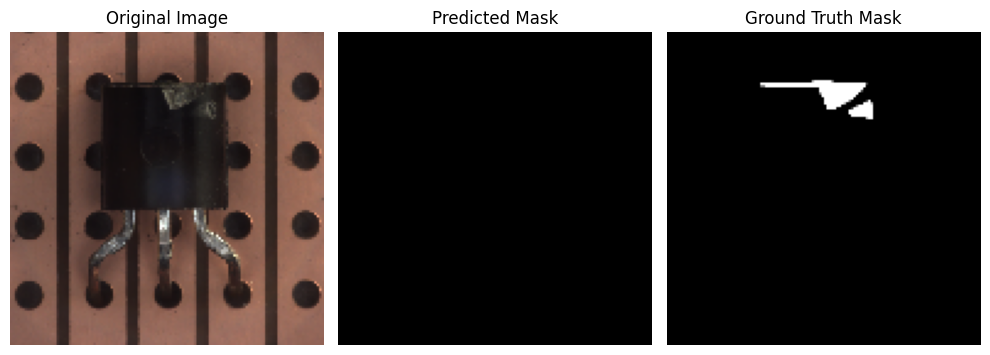

In [ ]:
# ===============================================
# 🧠 SVM Image Segmentation - Google Colab Script (Fixed)
# ===============================================

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Ask for directory
base_dir = input("Enter the path to your image directory (e.g. /content/images): ").strip()

# Expect subfolders: "images" and "masks"
image_dir = os.path.join(base_dir, "images")
mask_dir = os.path.join(base_dir, "masks")

if not os.path.exists(image_dir) or not os.path.exists(mask_dir):
    raise FileNotFoundError("Please make sure your directory contains 'images/' and 'masks/' subfolders.")

# Parameters
sample_pixels_per_image = 20000   # number of pixels to sample per image
test_ratio = 0.2                  # 20% of data for testing

# Load and prepare data
X = []
y = []

image_files = sorted([f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
mask_files = sorted([f for f in os.listdir(mask_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

print(f"Found {len(image_files)} images and {len(mask_files)} masks.")

for img_file, mask_file in zip(image_files, mask_files):
    img_path = os.path.join(image_dir, img_file)
    mask_path = os.path.join(mask_dir, mask_file)

    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if img is None or mask is None:
        print(f"⚠️ Skipping {img_file}, couldn't load.")
        continue

    img = cv2.resize(img, (128, 128))
    mask = cv2.resize(mask, (128, 128))

    img_flat = img.reshape(-1, 3)
    mask_flat = (mask.flatten() > 128).astype(np.uint8)

    total_pixels = len(mask_flat)
    n_samples = min(sample_pixels_per_image, total_pixels)  # ✅ avoid oversampling

    idx = np.random.choice(total_pixels, n_samples, replace=False)
    X.extend(img_flat[idx])
    y.extend(mask_flat[idx])

X = np.array(X)
y = np.array(y)

print(f"✅ Total training samples: {X.shape[0]} pixels")

# Shuffle and split
X, y = shuffle(X, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=42)

# Train SVM
print("🚀 Training SVM... (this may take a few minutes)")
clf = SVC(kernel='rbf', gamma='scale')
clf.fit(X_train, y_train)
print("✅ Training complete.")

# Test on one image
test_img_path = os.path.join(image_dir, image_files[0])
test_img = cv2.imread(test_img_path)
test_img = cv2.resize(test_img, (128, 128))
h, w, _ = test_img.shape

test_pixels = test_img.reshape(-1, 3)
pred_mask = clf.predict(test_pixels).reshape(h, w)

# Display
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Predicted Mask")
plt.imshow(pred_mask, cmap='gray')
plt.axis("off")

# Ground truth
gt_mask_path = os.path.join(mask_dir, mask_files[0])
gt_mask = cv2.imread(gt_mask_path, cv2.IMREAD_GRAYSCALE)
gt_mask = cv2.resize(gt_mask, (128, 128))
plt.subplot(1, 3, 3)
plt.title("Ground Truth Mask")
plt.imshow(gt_mask, cmap='gray')
plt.axis("off")

plt.tight_layout()
plt.show()


Enter the path to your image directory (e.g. /content/images): /content/drive/MyDrive/Good
Found 11 images and 11 masks.
✅ Total training samples: 180224 pixels
🚀 Training SVM... (this may take a few minutes)
✅ Training complete.


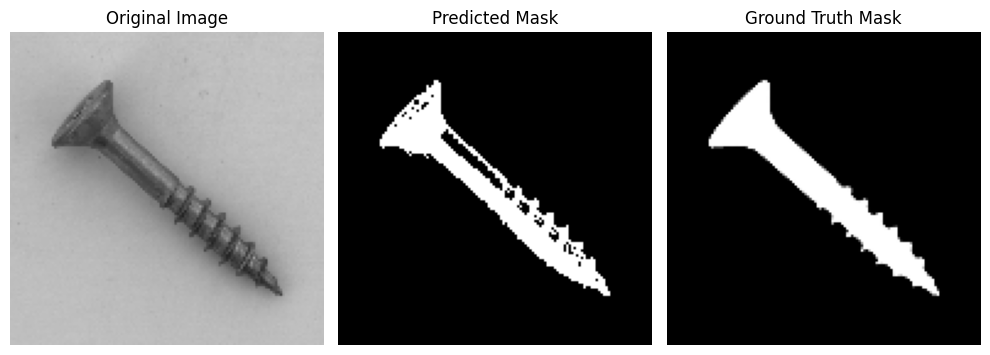

In [ ]:
# ===============================================
# 🧠 SVM Image Segmentation - Google Colab Script (Fixed)
# ===============================================

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Ask for directory
base_dir = input("Enter the path to your image directory (e.g. /content/images): ").strip()

# Expect subfolders: "images" and "masks"
image_dir = os.path.join(base_dir, "images")
mask_dir = os.path.join(base_dir, "masks")

if not os.path.exists(image_dir) or not os.path.exists(mask_dir):
    raise FileNotFoundError("Please make sure your directory contains 'images/' and 'masks/' subfolders.")

# Parameters
sample_pixels_per_image = 20000   # number of pixels to sample per image
test_ratio = 0.2                  # 20% of data for testing

# Load and prepare data
X = []
y = []

image_files = sorted([f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
mask_files = sorted([f for f in os.listdir(mask_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

print(f"Found {len(image_files)} images and {len(mask_files)} masks.")

for img_file, mask_file in zip(image_files, mask_files):
    img_path = os.path.join(image_dir, img_file)
    mask_path = os.path.join(mask_dir, mask_file)

    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if img is None or mask is None:
        print(f"⚠️ Skipping {img_file}, couldn't load.")
        continue

    img = cv2.resize(img, (128, 128))
    mask = cv2.resize(mask, (128, 128))

    img_flat = img.reshape(-1, 3)
    mask_flat = (mask.flatten() > 128).astype(np.uint8)

    total_pixels = len(mask_flat)
    n_samples = min(sample_pixels_per_image, total_pixels)  # ✅ avoid oversampling

    idx = np.random.choice(total_pixels, n_samples, replace=False)
    X.extend(img_flat[idx])
    y.extend(mask_flat[idx])

X = np.array(X)
y = np.array(y)

print(f"✅ Total training samples: {X.shape[0]} pixels")

# Shuffle and split
X, y = shuffle(X, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=42)

# Train SVM
print("🚀 Training SVM... (this may take a few minutes)")
clf = SVC(kernel='rbf', gamma='scale')
clf.fit(X_train, y_train)
print("✅ Training complete.")

# Test on one image
test_img_path = os.path.join(image_dir, image_files[0])
test_img = cv2.imread(test_img_path)
test_img = cv2.resize(test_img, (128, 128))
h, w, _ = test_img.shape

test_pixels = test_img.reshape(-1, 3)
pred_mask = clf.predict(test_pixels).reshape(h, w)

# Display
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Predicted Mask")
plt.imshow(pred_mask, cmap='gray')
plt.axis("off")

# Ground truth
gt_mask_path = os.path.join(mask_dir, mask_files[0])
gt_mask = cv2.imread(gt_mask_path, cv2.IMREAD_GRAYSCALE)
gt_mask = cv2.resize(gt_mask, (128, 128))
plt.subplot(1, 3, 3)
plt.title("Ground Truth Mask")
plt.imshow(gt_mask, cmap='gray')
plt.axis("off")

plt.tight_layout()
plt.show()


RANDOM FOREST IMAGE SEGMENTATION - LOCAL VERSION

######################################################################
# RANDOM FOREST IMAGE SEGMENTATION
######################################################################

Enter your dataset path:
Example (Windows): C:\Users\YourName\Desktop\my_dataset
Example (Mac/Linux): /home/yourname/Desktop/my_dataset

Your dataset should have this structure:
  my_dataset/
    ├── images/
    │   ├── img1.jpg
    │   ├── img2.jpg
    └── masks/
        ├── img1.png
        ├── img2.png

Dataset path: /content/drive/MyDrive/Good2

######################################################################
# RANDOM FOREST IMAGE SEGMENTATION PIPELINE
######################################################################

STEP 1: LOAD DATASET

✓ Loading dataset from: /content/drive/MyDrive/Good2
  Found 11 images

✓ Successfully loaded 11 image-mask pairs
  Classes found in masks: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  1

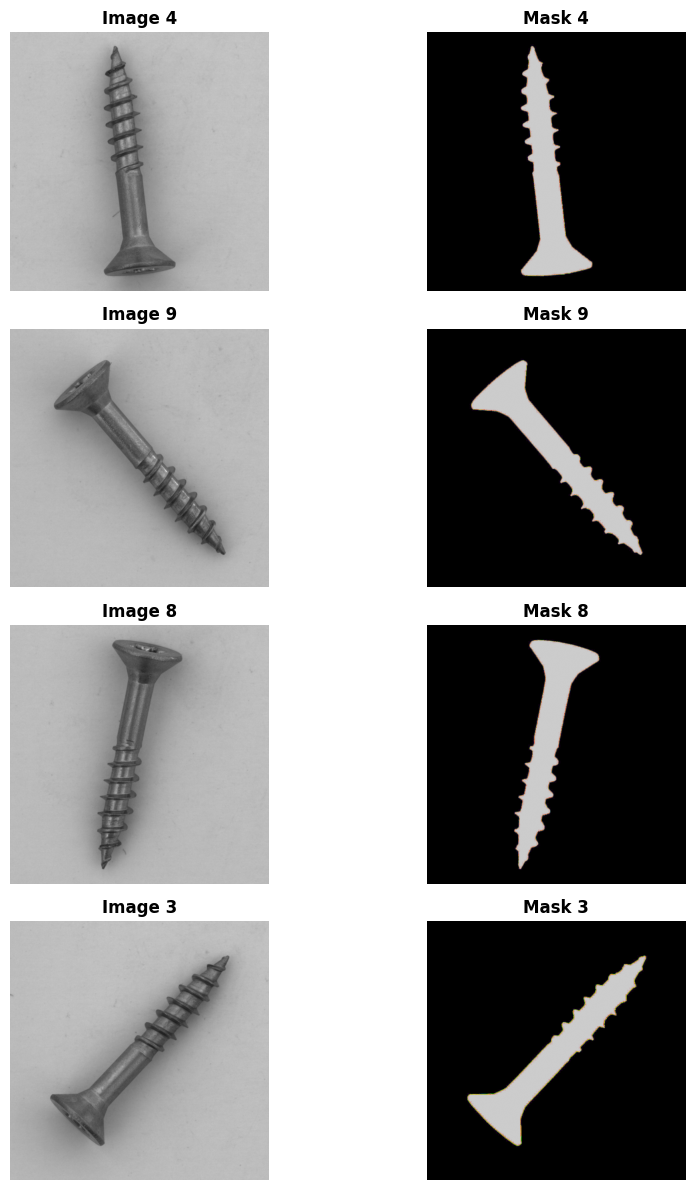


PREPARING TRAINING DATA

✓ Processing 11 images...
  Processing image 1/11...
✓ Extracting multi-scale features (σ=1 to 16)...
  Feature shape: (1024, 1024, 60)
  Features per pixel: 60
  Processing image 2/11...
✓ Extracting multi-scale features (σ=1 to 16)...
  Feature shape: (1024, 1024, 60)
  Features per pixel: 60
  Processing image 3/11...
✓ Extracting multi-scale features (σ=1 to 16)...
  Feature shape: (1024, 1024, 60)
  Features per pixel: 60
  Processing image 4/11...
✓ Extracting multi-scale features (σ=1 to 16)...
  Feature shape: (1024, 1024, 60)
  Features per pixel: 60
  Processing image 5/11...
✓ Extracting multi-scale features (σ=1 to 16)...
  Feature shape: (1024, 1024, 60)
  Features per pixel: 60
  Processing image 6/11...
✓ Extracting multi-scale features (σ=1 to 16)...
  Feature shape: (1024, 1024, 60)
  Features per pixel: 60
  Processing image 7/11...
✓ Extracting multi-scale features (σ=1 to 16)...
  Feature shape: (1024, 1024, 60)
  Features per pixel: 60
  P

In [ ]:
# ============================================
# RANDOM FOREST IMAGE SEGMENTATION
# Complete Code for Jupyter Lab (Local Machine)
# Works with Images + Masks
# ============================================

# Install libraries (run once in terminal)
# pip install scikit-learn scikit-image opencv-python matplotlib numpy scipy seaborn

import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import segmentation, feature, color, filters
from skimage.filters import gaussian, sobel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("RANDOM FOREST IMAGE SEGMENTATION - LOCAL VERSION")
print("="*70)

# ============================================
# 1. LOAD IMAGES AND MASKS FROM FOLDER
# ============================================

def load_segmentation_dataset(dataset_path, img_folder='images', mask_folder='masks'):
    """
    Load segmentation dataset from folder structure:

    dataset_path/
      ├── images/
      │   ├── img1.jpg
      │   ├── img2.jpg
      └── masks/
          ├── img1.png
          ├── img2.png

    Returns:
    - images: array of RGB images
    - masks: array of corresponding masks
    - filenames: list of filenames
    """
    print(f"\n✓ Loading dataset from: {dataset_path}")

    images_path = os.path.join(dataset_path, img_folder)
    masks_path = os.path.join(dataset_path, mask_folder)

    # Check if paths exist
    if not os.path.exists(images_path):
        raise ValueError(f"Images folder not found: {images_path}")
    if not os.path.exists(masks_path):
        raise ValueError(f"Masks folder not found: {masks_path}")

    # Get list of image files
    image_files = sorted([f for f in os.listdir(images_path)
                         if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))])

    print(f"  Found {len(image_files)} images")

    images = []
    masks = []
    filenames = []
    loaded_count = 0

    for img_file in image_files:
        # Create mask filename (same name, but .png)
        mask_file = os.path.splitext(img_file)[0] + '.png'

        img_path = os.path.join(images_path, img_file)
        mask_path = os.path.join(masks_path, mask_file)

        # Check if corresponding mask exists
        if not os.path.exists(mask_path):
            print(f"  ⚠ Warning: Mask not found for {img_file}, skipping...")
            continue

        try:
            # Load image (RGB)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Load mask (grayscale)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            # Ensure same size
            if img.shape[:2] != mask.shape:
                mask = cv2.resize(mask, (img.shape[1], img.shape[0]),
                                 interpolation=cv2.INTER_NEAREST)

            images.append(img)
            masks.append(mask)
            filenames.append(img_file)
            loaded_count += 1

        except Exception as e:
            print(f"  ✗ Error loading {img_file}: {e}")

    print(f"\n✓ Successfully loaded {loaded_count} image-mask pairs")

    if len(masks) > 0:
        unique_classes = np.unique(np.concatenate([m.ravel() for m in masks]))
        print(f"  Classes found in masks: {unique_classes}")

    return np.array(images), np.array(masks), filenames

def visualize_dataset_samples(images, masks, n_samples=4):
    """
    Visualize sample images with their masks
    """
    print(f"\n✓ Visualizing {n_samples} samples from dataset...")

    indices = np.random.choice(len(images), min(n_samples, len(images)), replace=False)

    fig, axes = plt.subplots(n_samples, 2, figsize=(10, 3*n_samples))
    if n_samples == 1:
        axes = axes.reshape(1, -1)

    for i, idx in enumerate(indices):
        # Original image
        axes[i, 0].imshow(images[idx])
        axes[i, 0].set_title(f'Image {idx}', fontweight='bold')
        axes[i, 0].axis('off')

        # Mask
        axes[i, 1].imshow(masks[idx], cmap='nipy_spectral')
        axes[i, 1].set_title(f'Mask {idx}', fontweight='bold')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# ============================================
# 2. FEATURE EXTRACTION FOR SEGMENTATION
# ============================================

def extract_multiscale_features(img, sigma_min=1, sigma_max=16):
    """
    Extract multi-scale features for each pixel

    Features include:
    - Intensity (color channels)
    - Edges (gradient magnitude)
    - Texture (at different scales)
    """
    print(f"\n✓ Extracting multi-scale features (σ={sigma_min} to {sigma_max})...")

    # Use scikit-image's built-in feature extraction
    features = feature.multiscale_basic_features(
        img,
        intensity=True,
        edges=True,
        texture=True,
        sigma_min=sigma_min,
        sigma_max=sigma_max,
        channel_axis=-1
    )

    print(f"  Feature shape: {features.shape}")
    print(f"  Features per pixel: {features.shape[2]}")

    return features

def extract_custom_features(img):
    """
    Extract custom features for segmentation
    """
    print("\n✓ Extracting custom features...")

    feature_list = []

    # Convert to different color spaces
    gray = color.rgb2gray(img)
    hsv = color.rgb2hsv(img)

    # Original RGB channels
    feature_list.append(img[:, :, 0])  # R
    feature_list.append(img[:, :, 1])  # G
    feature_list.append(img[:, :, 2])  # B

    # HSV channels
    feature_list.append(hsv[:, :, 0])  # Hue
    feature_list.append(hsv[:, :, 1])  # Saturation
    feature_list.append(hsv[:, :, 2])  # Value

    # Grayscale intensity
    feature_list.append(gray)

    # Edges (Sobel)
    edges = sobel(gray)
    feature_list.append(edges)

    # Texture features (Gaussian at different scales)
    for sigma in [1, 3, 5, 10]:
        blurred = gaussian(gray, sigma=sigma)
        feature_list.append(blurred)

    # Stack features
    features = np.stack(feature_list, axis=-1)

    print(f"  Feature shape: {features.shape}")
    print(f"  Features per pixel: {features.shape[2]}")

    return features

# ============================================
# 3. PREPARE DATA FOR TRAINING
# ============================================

def prepare_training_data(images, masks, feature_method='multiscale'):
    """
    Extract features from all images and prepare for training

    Returns:
    - X_all: All pixel features
    - y_all: All pixel labels
    - feature_list: List of feature arrays for each image
    """
    print("\n" + "="*70)
    print("PREPARING TRAINING DATA")
    print("="*70)

    X_all = []
    y_all = []
    feature_list = []

    print(f"\n✓ Processing {len(images)} images...")

    for i, (img, mask) in enumerate(zip(images, masks)):
        print(f"  Processing image {i+1}/{len(images)}...", end='\r')

        # Extract features
        if feature_method == 'multiscale':
            features = extract_multiscale_features(img)
        else:
            features = extract_custom_features(img)

        feature_list.append(features)

        # Flatten for training
        X = features.reshape(-1, features.shape[-1])
        y = mask.ravel()

        # Only use labeled pixels (mask > 0)
        labeled_mask = y > 0
        X_labeled = X[labeled_mask]
        y_labeled = y[labeled_mask]

        X_all.append(X_labeled)
        y_all.append(y_labeled)

    # Concatenate all data
    X_train = np.concatenate(X_all, axis=0)
    y_train = np.concatenate(y_all, axis=0)

    print(f"\n✓ Data preparation complete!")
    print(f"  Total labeled pixels: {len(X_train)}")
    print(f"  Classes: {np.unique(y_train)}")
    print(f"  Feature dimension: {X_train.shape[1]}")

    return X_train, y_train, feature_list

# ============================================
# 4. TRAIN RANDOM FOREST CLASSIFIER
# ============================================

def train_random_forest(X_train, y_train, n_estimators=100, max_depth=20):
    """
    Train Random Forest classifier for segmentation
    """
    print("\n" + "="*70)
    print("TRAINING RANDOM FOREST CLASSIFIER")
    print("="*70)

    print(f"\n✓ Training with {n_estimators} trees, max_depth={max_depth}...")

    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=10,
        min_samples_leaf=5,
        n_jobs=-1,
        random_state=42,
        verbose=0
    )

    clf.fit(X_train, y_train)

    print("  ✓ Training complete!")

    # Feature importance
    importances = clf.feature_importances_
    print(f"\n  Feature importance range: {importances.min():.4f} - {importances.max():.4f}")

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(importances)), importances)
    plt.xlabel('Feature Index', fontsize=12, fontweight='bold')
    plt.ylabel('Importance', fontsize=12, fontweight='bold')
    plt.title('Feature Importance', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    return clf

# ============================================
# 5. PREDICT SEGMENTATION
# ============================================

def predict_segmentation(clf, features):
    """
    Predict segmentation for an image

    Parameters:
    - clf: trained classifier
    - features: feature array (height, width, n_features)

    Returns:
    - segmentation: predicted mask (height, width)
    """
    # Flatten features
    X = features.reshape(-1, features.shape[-1])

    # Predict all pixels
    y_pred = clf.predict(X)

    # Reshape to image shape
    segmentation = y_pred.reshape(features.shape[:2])

    return segmentation

def predict_batch(clf, images, feature_method='multiscale'):
    """
    Predict segmentation for multiple images
    """
    print("\n✓ Predicting segmentation for all images...")

    segmentations = []

    for i, img in enumerate(images):
        print(f"  Processing image {i+1}/{len(images)}...", end='\r')

        # Extract features
        if feature_method == 'multiscale':
            features = extract_multiscale_features(img)
        else:
            features = extract_custom_features(img)

        # Predict
        seg = predict_segmentation(clf, features)
        segmentations.append(seg)

    print(f"\n  ✓ Segmentation complete!")

    return np.array(segmentations)

# ============================================
# 6. EVALUATE SEGMENTATION
# ============================================

def evaluate_segmentation(masks_true, masks_pred):
    """
    Evaluate segmentation accuracy
    """
    print("\n" + "="*70)
    print("EVALUATION METRICS")
    print("="*70)

    # Flatten all masks
    y_true_all = []
    y_pred_all = []

    for mask_true, mask_pred in zip(masks_true, masks_pred):
        # Only evaluate labeled pixels
        labeled_mask = mask_true > 0
        y_true_all.append(mask_true[labeled_mask])
        y_pred_all.append(mask_pred[labeled_mask])

    y_true = np.concatenate(y_true_all)
    y_pred = np.concatenate(y_pred_all)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    print(f"\n✓ Overall Pixel-wise Accuracy: {accuracy:.4f}")

    # Classification report
    print("\n✓ Classification Report:")
    print(classification_report(y_true, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
    plt.ylabel('True Class', fontsize=12)
    plt.xlabel('Predicted Class', fontsize=12)
    plt.tight_layout()
    plt.show()

    return accuracy, cm

# ============================================
# 7. VISUALIZE RESULTS
# ============================================

def visualize_segmentation_results(images, masks_true, masks_pred, n_samples=4):
    """
    Visualize segmentation results
    """
    print("\n✓ Visualizing segmentation results...")

    indices = np.random.choice(len(images), min(n_samples, len(images)), replace=False)

    fig, axes = plt.subplots(n_samples, 4, figsize=(16, 4*n_samples))
    if n_samples == 1:
        axes = axes.reshape(1, -1)

    for i, idx in enumerate(indices):
        # Original image
        axes[i, 0].imshow(images[idx])
        axes[i, 0].set_title('Original Image', fontweight='bold')
        axes[i, 0].axis('off')

        # True mask
        axes[i, 1].imshow(masks_true[idx], cmap='nipy_spectral')
        axes[i, 1].set_title('Ground Truth Mask', fontweight='bold')
        axes[i, 1].axis('off')

        # Predicted mask
        axes[i, 2].imshow(masks_pred[idx], cmap='nipy_spectral')
        axes[i, 2].set_title('Predicted Mask', fontweight='bold')
        axes[i, 2].axis('off')

        # Overlay
        axes[i, 3].imshow(segmentation.mark_boundaries(images[idx], masks_pred[idx], mode='thick'))
        axes[i, 3].set_title('Boundaries', fontweight='bold')
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()

def visualize_each_class(img, segmentation, class_names=None):
    """
    Visualize each segmented class separately
    """
    classes = np.unique(segmentation)
    classes = classes[classes > 0]  # Exclude background
    n_classes = len(classes)

    fig, axes = plt.subplots(1, n_classes + 1, figsize=(4 * (n_classes + 1), 4))
    if n_classes == 0:
        print("No classes found in segmentation!")
        return

    # Original
    axes[0].imshow(img)
    axes[0].set_title('Original', fontweight='bold')
    axes[0].axis('off')

    # Each class
    for i, cls in enumerate(classes):
        mask = (segmentation == cls)
        masked_img = img.copy()
        masked_img[~mask] = 0

        if class_names and cls-1 < len(class_names):
            title = f'{class_names[cls-1]}'
        else:
            title = f'Class {cls}'

        axes[i + 1].imshow(masked_img)
        axes[i + 1].set_title(title, fontweight='bold')
        axes[i + 1].axis('off')

    plt.tight_layout()
    plt.show()

# ============================================
# 8. COMPLETE PIPELINE
# ============================================

def run_rf_segmentation_pipeline(dataset_path, feature_method='multiscale',
                                  n_estimators=100, max_depth=20):
    """
    Complete Random Forest segmentation pipeline

    Parameters:
    - dataset_path: Path to dataset folder (with 'images' and 'masks' subfolders)
    - feature_method: 'multiscale' or 'custom'
    - n_estimators: Number of trees in Random Forest
    - max_depth: Maximum depth of trees
    """
    print("\n" + "#"*70)
    print("# RANDOM FOREST IMAGE SEGMENTATION PIPELINE")
    print("#"*70)

    # Step 1: Load dataset
    print("\n" + "="*70)
    print("STEP 1: LOAD DATASET")
    print("="*70)

    images, masks, filenames = load_segmentation_dataset(dataset_path)

    if len(images) == 0:
        print("✗ No images loaded! Check your dataset path.")
        return None

    # Visualize samples
    visualize_dataset_samples(images, masks, n_samples=min(4, len(images)))

    # Step 2: Prepare training data
    X_train, y_train, feature_list = prepare_training_data(
        images, masks, feature_method=feature_method
    )

    # Step 3: Train Random Forest
    clf = train_random_forest(X_train, y_train,
                              n_estimators=n_estimators,
                              max_depth=max_depth)

    # Step 4: Predict on all images
    print("\n" + "="*70)
    print("STEP 4: PREDICT SEGMENTATION")
    print("="*70)

    masks_pred = predict_batch(clf, images, feature_method=feature_method)

    # Step 5: Evaluate
    accuracy, cm = evaluate_segmentation(masks, masks_pred)

    # Step 6: Visualize results
    print("\n" + "="*70)
    print("STEP 6: VISUALIZE RESULTS")
    print("="*70)

    visualize_segmentation_results(images, masks, masks_pred,
                                   n_samples=min(4, len(images)))

    # Visualize class separation for first image
    if len(images) > 0:
        print("\n✓ Visualizing class separation for first image...")
        visualize_each_class(images[0], masks_pred[0])

    print("\n" + "="*70)
    print("SEGMENTATION COMPLETE!")
    print("="*70)
    print(f"\n✓ Final Accuracy: {accuracy:.4f}")
    print(f"✓ Model trained on {len(X_train)} pixels")
    print(f"✓ Segmented {len(images)} images")

    return clf, images, masks, masks_pred, feature_list

# ============================================
# 9. SEGMENT NEW IMAGE
# ============================================

def segment_new_image(clf, image_path, feature_method='multiscale'):
    """
    Segment a new image using trained model
    """
    print(f"\n✓ Segmenting new image: {image_path}")

    # Load image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Extract features
    if feature_method == 'multiscale':
        features = extract_multiscale_features(img)
    else:
        features = extract_custom_features(img)

    # Predict
    segmentation = predict_segmentation(clf, features)

    # Visualize
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(img)
    axes[0].set_title('Original Image', fontweight='bold')
    axes[0].axis('off')

    axes[1].imshow(segmentation, cmap='nipy_spectral')
    axes[1].set_title('Segmentation', fontweight='bold')
    axes[1].axis('off')

    axes[2].imshow(segmentation.mark_boundaries(img, segmentation, mode='thick'))
    axes[2].set_title('Boundaries', fontweight='bold')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    return segmentation

# ============================================
# MAIN EXECUTION
# ============================================

if __name__ == "__main__":

    print("\n" + "#"*70)
    print("# RANDOM FOREST IMAGE SEGMENTATION")
    print("#"*70)

    # Input your dataset path
    print("\nEnter your dataset path:")
    print("Example (Windows): C:\\Users\\YourName\\Desktop\\my_dataset")
    print("Example (Mac/Linux): /home/yourname/Desktop/my_dataset")
    print("\nYour dataset should have this structure:")
    print("  my_dataset/")
    print("    ├── images/")
    print("    │   ├── img1.jpg")
    print("    │   ├── img2.jpg")
    print("    └── masks/")
    print("        ├── img1.png")
    print("        ├── img2.png")

    dataset_path = input("\nDataset path: ").strip()

    # Remove quotes if user copied path with quotes
    dataset_path = dataset_path.strip('"').strip("'")

    # Check if path exists
    if not os.path.exists(dataset_path):
        print(f"\n✗ Error: Path not found: {dataset_path}")
        print("Please check the path and try again.")
    else:
        # Run pipeline
        clf, images, masks_true, masks_pred, features = run_rf_segmentation_pipeline(
            dataset_path=dataset_path,
            feature_method='multiscale',  # or 'custom'
            n_estimators=100,
            max_depth=20
        )

        print("\n✅ Your Random Forest segmentation model is ready!")
        print("\nTo segment a new image:")
        print("""
        new_seg = segment_new_image(clf, 'path/to/new_image.jpg',
                                     feature_method='multiscale')
        """)
